In [1]:
START_NUM=750;
END_NUM=900;

### Goal: Feature Importance.

The idea is to use the permutation importance to the neural network.
1. Fit the model with all the features of interest.
2. For each column:
  - Randomly permute the values in the column
  - Compute the drop in training RMSE
  - The more important the feature is, theoretically the more is the performance drop.

In [2]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error;

2.6.0


In [3]:
pd.set_option('display.max_columns', 300);
pd.set_option('display.max_rows', 300);
tf.keras.backend.set_floatx('float64');

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [5]:
MONTHS = 60;
SPLIT = 48; # 2015-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 24;
WINDOW_SIZE = 1;

TEST_LENGTH = MONTHS - SPLIT;

### Data preparation

In [6]:
multi_data = pd.read_csv('../data/full_dataset_unscaled.csv', index_col = 0);
zip_ids = multi_data.index.unique();

multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
                 axis = 1, inplace = True);

multi_data.head()

zri  percent_white  percent_black  percent_asian  percent_hispanic  \
zip                                                                          
1013  946.0       0.714892       0.023829       0.013748          0.230129   
1013  950.0       0.715367       0.024195       0.014023          0.229024   
1013  958.0       0.715842       0.024561       0.014299          0.227919   
1013  958.0       0.716318       0.024927       0.014574          0.226813   
1013  955.0       0.716793       0.025294       0.014850          0.225708   

      percent_native_am  percent_other_race  percent_0_17  percent_18_39  \
zip                                                                        
1013           0.000113            0.004539      0.224062       0.314378   
1013           0.000226            0.004587      0.223443       0.316319   
1013           0.000339            0.004634      0.222823       0.318260   
1013           0.000452            0.004682      0.222204       0.320201   
1013           0.000565            0.004730      0.221584       0.322142   

      percent_40_64  percent_65+  percent_rental_units_vacant  \
zip                                                             
1013       0.316595     0.144965                     0.057735   
1013       0.315346     0.144892                     0.057503   
1013       0.314097     0.144820                     0.057270   
1013       0.312847     0.144748                     0.057038   
1013       0.311598     0.144675                     0.056805   

      percent_rental_units_occupied  percent_graduate_deg  percent_bachelors  \
zip                                                                            
1013                       0.942265              0.029555           0.062456   
1013                       0.942497              0.029598           0.062682   
1013                       0.942730              0.029641           0.062908   
1013                       0.942962              0.029684           0.063134   
1013                       0.943195              0.029727           0.063359   

      percent_associates  percent_highschool  percent_less_highschool  \
zip                                                                     
1013            0.257328            0.383459                 0.218492   
1013            0.255708            0.385186                 0.217890   
1013            0.254088            0.386912                 0.217289   
1013            0.252468            0.388639                 0.216687   
1013            0.250848            0.390365                 0.216086   

      percent_commute_public_transport  percent_commute_less_30  \
zip                                                               
1013                          0.022609                 0.731245   
1013                          0.023198                 0.733361   
1013                          0.023787                 0.735477   
1013                          0.024375                 0.737593   
1013                          0.024964                 0.739709   

      percent_buildings_less_10_units  percent_buildings_10_19_units  \
zip                                                                    
1013                         0.883422                       0.030202   
1013                         0.883598                       0.030477   
1013                         0.883775                       0.030752   
1013                         0.883952                       0.031027   
1013                         0.884128                       0.031302   

      percent_buildings_20_49_units  percent_buildings_50+_units  \
zip                                                                
1013                       0.036863                     0.049514   
1013                       0.036368                     0.049557   
1013                       0.035873                     0.049601   
1013                       0.035378                     0.049644   
1013            

In [7]:
FEATURES = multi_data.shape[1] - 1;

feature_name = list(multi_data.columns);

### Utility functions

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1, 1:], window[-1][0]));
    dataset = dataset.batch(batch_size).prefetch(1);
    return dataset;

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)

### Neural network center

In [10]:
def NN_model(dataset, termination=0, test = None):
    tf.keras.backend.clear_session();
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    class myCallbacks(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            mse = logs.get("mse");
            if(mse < termination):
                print("\nGot an mse at {:.4f} in epoch {} and stopped training\n".format(mse, epoch));
                self.model.stop_training = True;
            
    callback = myCallbacks();
    
    model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                           input_shape=[None]),
#       tf.keras.layers.Conv1D(filters=32, kernel_size=3,
#                           strides=1, padding="causal",
#                           activation="relu",
#                           input_shape=[None, WINDOW_SIZE, FEATURES+1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, input_shape = [None, WINDOW_SIZE, FEATURES])),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        # tf.keras.layers.SimpleRNN(8, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        tf.keras.layers.Dense(8, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 2.0)
    ]);
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])

    model.build((None,WINDOW_SIZE,FEATURES))
    # model.summary()

    if not test: history = model.fit(dataset, epochs=500, callbacks = [callback], verbose = 0);
    else: history = model.fit(dataset, epochs=500, validation_data=test,\
                              callbacks=[callback], verbose = 0);
    return model;

In [11]:
def NN_forecast(model, series_transformed):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, 1:]))

    results = [float(x[-1][0]) for x in forecast];
    actual = list(series_transformed[WINDOW_SIZE:, 0]);
    
    return results, actual;

In [12]:
@tf.autograph.experimental.do_not_convert
def NN_test(ZONE, termination=0, plot=False):
    '''
    Input: ZONE
    Output: the RMSE of a NN model on the predicted train, partially predicted test, and complete predicted test.
    '''
    # Collection of data
    series_frame = multi_data[multi_data.index == ZONE];
    # series_frame.sort_values("datetime", ascending = True, inplace = True);
    
    # Standardization
    scaler = MinMaxScaler();
    series_transformed = scaler.fit_transform(series_frame);
    
    # Train test split
    series_train = series_transformed[:SPLIT];
    series_test = series_transformed[SPLIT-WINDOW_SIZE:];
    
    # Window the training set to make input of the NN
    dataset_train = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, 60);
    # dataset_test = windowed_dataset(series_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
#     for x, y in dataset_train:
#         print(np.array(x).shape, np.array(y).shape);
    
    model = NN_model(dataset_train, termination);
    
    time_train = list(range(SPLIT));
    time_test = list(range(SPLIT, MONTHS));
    
    # Forecasting
    results, actual = NN_forecast(model, series_transformed);
    
    # Compute MSE
    MSE_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * scaler.data_range_[0];
    MSE_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * scaler.data_range_[0];
    
    if plot: # If the plot option is selected, plot the graph.
        time_actual = range(WINDOW_SIZE, MONTHS);
        plt.figure(figsize=(10, 6))
        plot_series(time_actual, np.array(actual)*scaler.data_range_[0]+scaler.data_min_[0]);
        plot_series(time_actual, np.array(results)*scaler.data_range_[0]+scaler.data_min_[0]);
        plt.show();

    return MSE_train, MSE_test, model, scaler, series_transformed;

### The script


Got an mse at 0.0024 in epoch 60 and stopped training



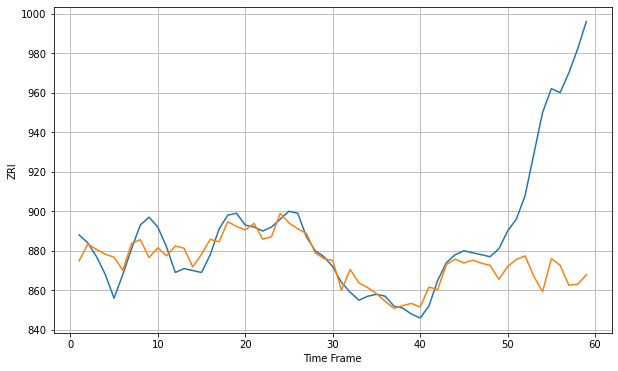

Wall time: 10.5 s
46143 7.355036775184816 76.99186950073513


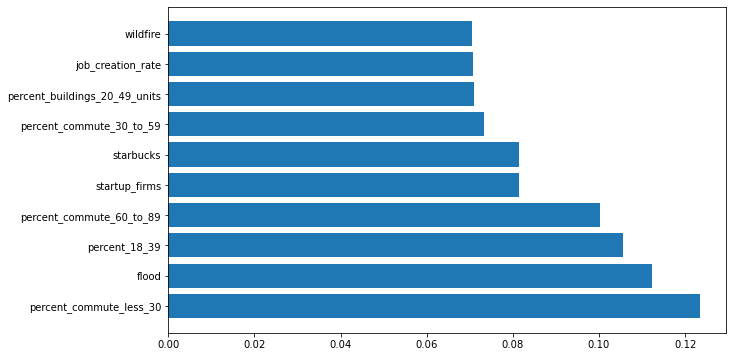


Got an mse at 0.0025 in epoch 68 and stopped training



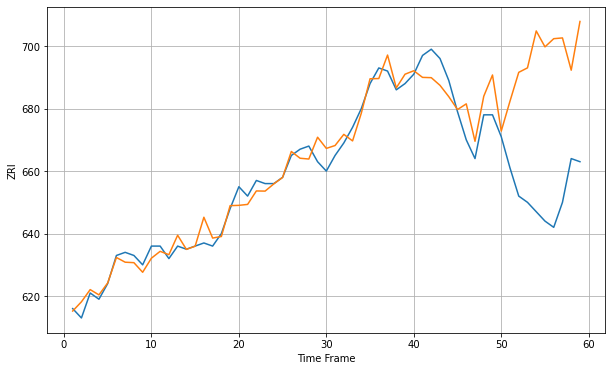

Wall time: 9.83 s
46201 4.242006749851254 40.573190571190025


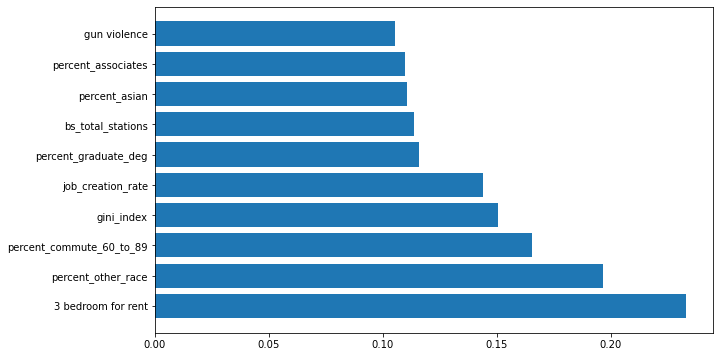


Got an mse at 0.0025 in epoch 141 and stopped training



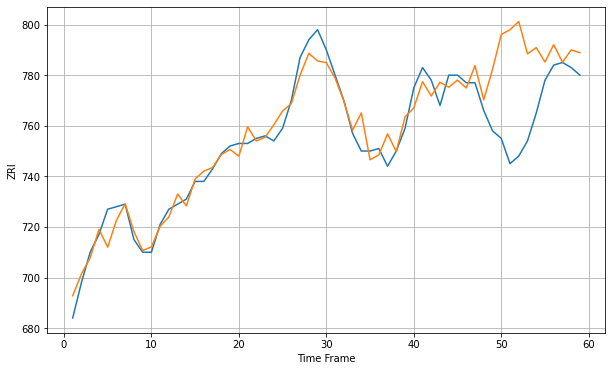

Wall time: 13.1 s
46203 5.763956802626733 28.91689452761055


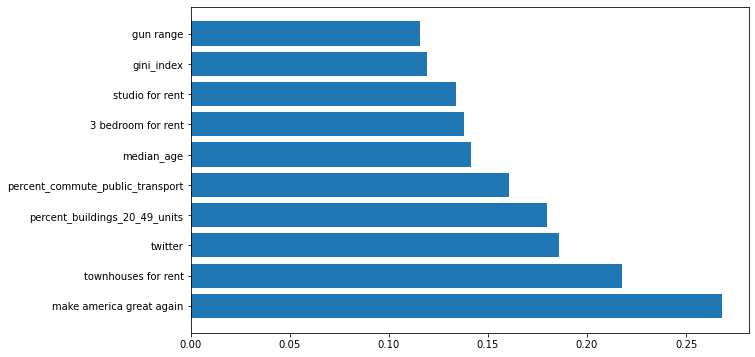


Got an mse at 0.0024 in epoch 63 and stopped training



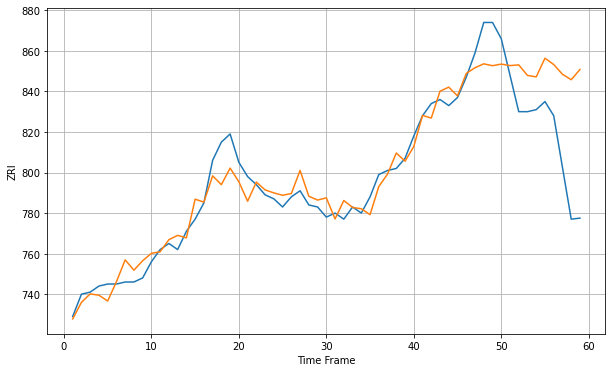

Wall time: 9.7 s
46208 7.020506682862346 35.906844575583676


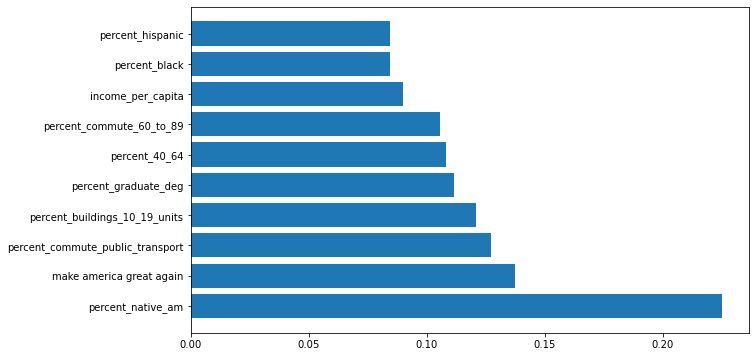


Got an mse at 0.0025 in epoch 154 and stopped training



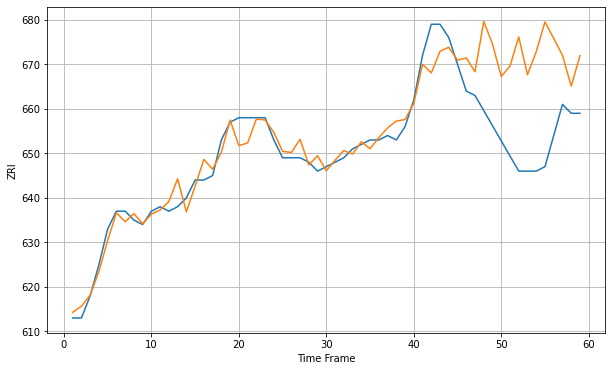

Wall time: 12.5 s
46219 3.2767099920545433 21.046609834981783


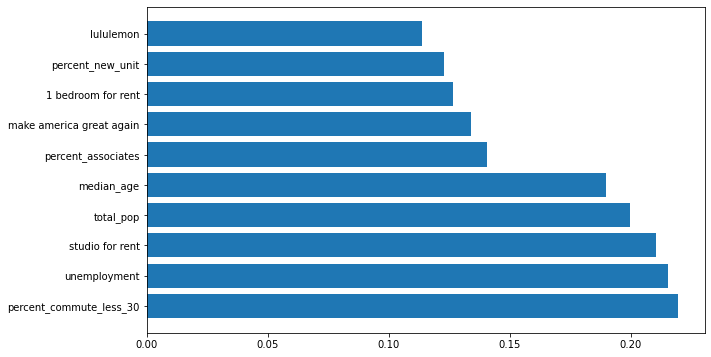


Got an mse at 0.0025 in epoch 48 and stopped training



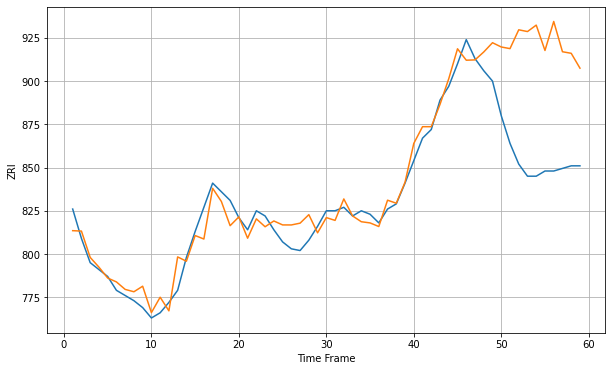

Wall time: 8.79 s
46312 7.890890465729076 64.66284126567035


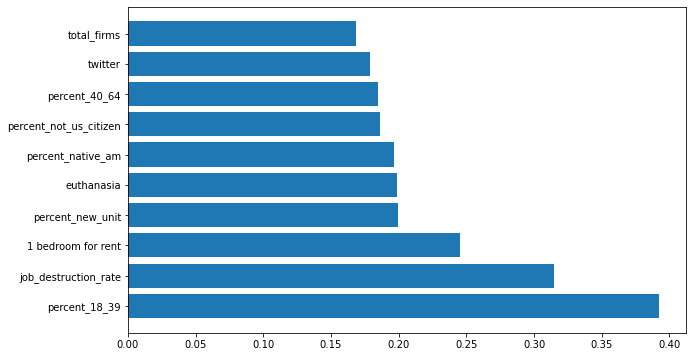


Got an mse at 0.0025 in epoch 85 and stopped training



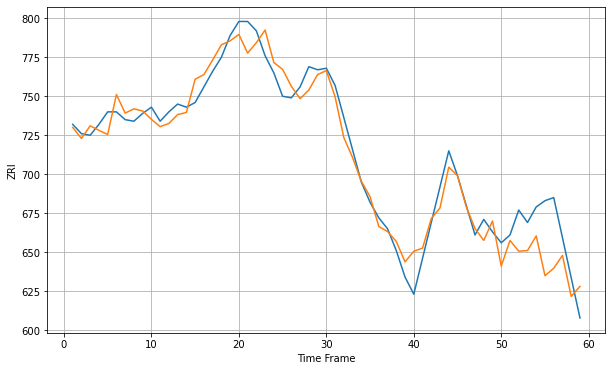

Wall time: 10.4 s
47374 9.367014830132508 23.956414745655305


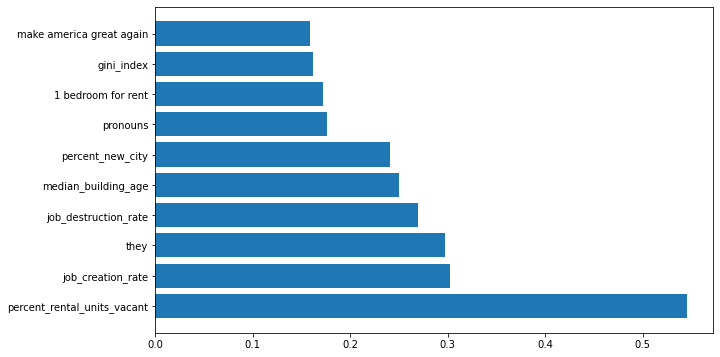


Got an mse at 0.0024 in epoch 83 and stopped training



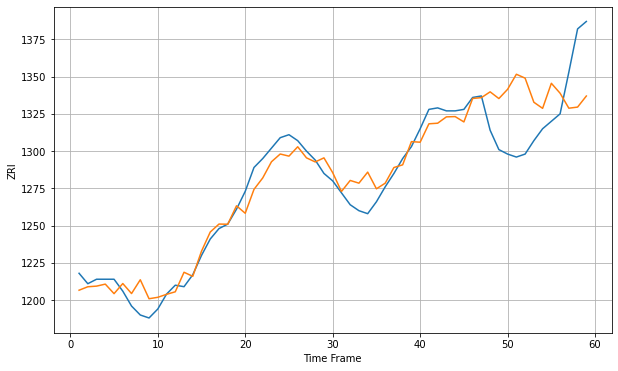

Wall time: 10.6 s
47401 9.666065120139942 37.58445119191332


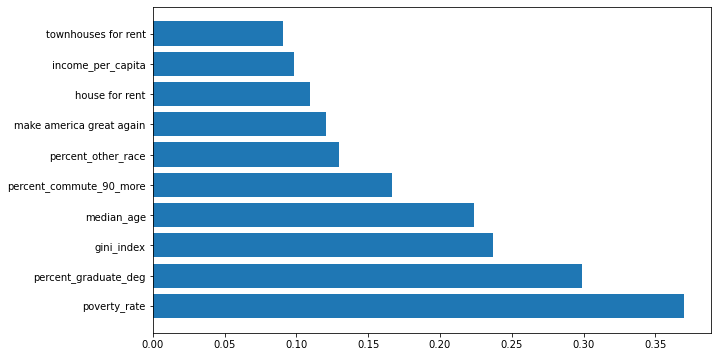


Got an mse at 0.0025 in epoch 105 and stopped training



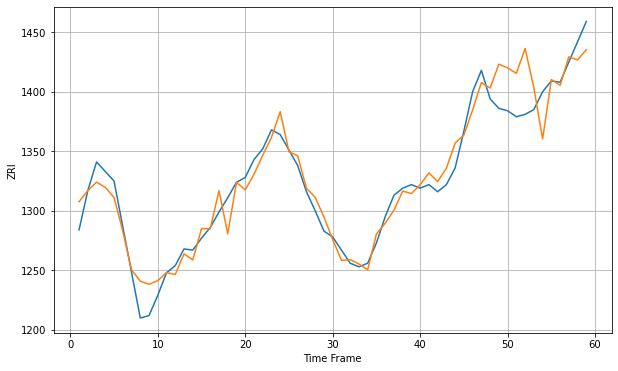

Wall time: 11.2 s
47408 12.294068730007371 28.694536207387145


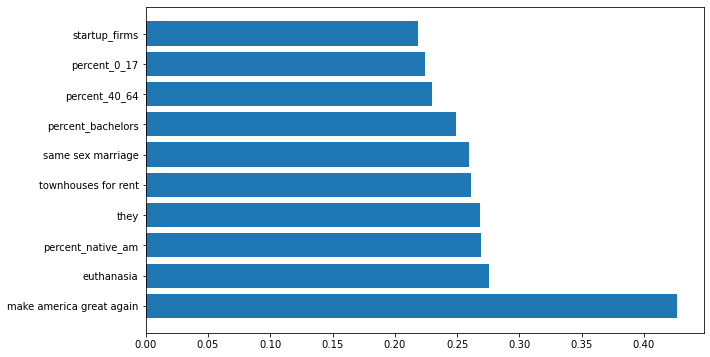


Got an mse at 0.0024 in epoch 44 and stopped training



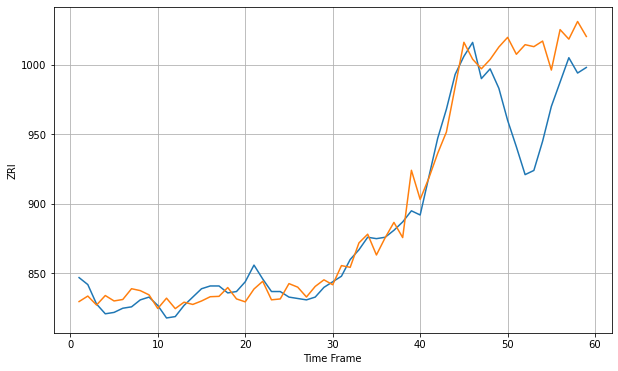

Wall time: 9.09 s
48186 9.61779616030979 53.898071691716524


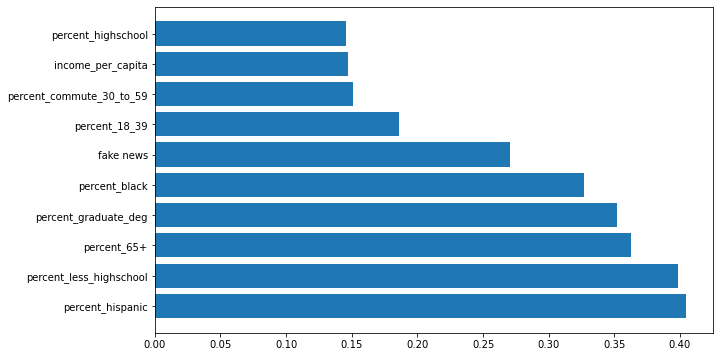


Got an mse at 0.0024 in epoch 57 and stopped training



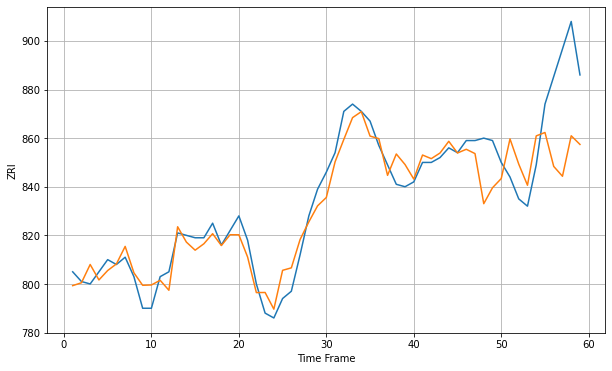

Wall time: 9.34 s
48195 5.909590194272222 27.52319880470014


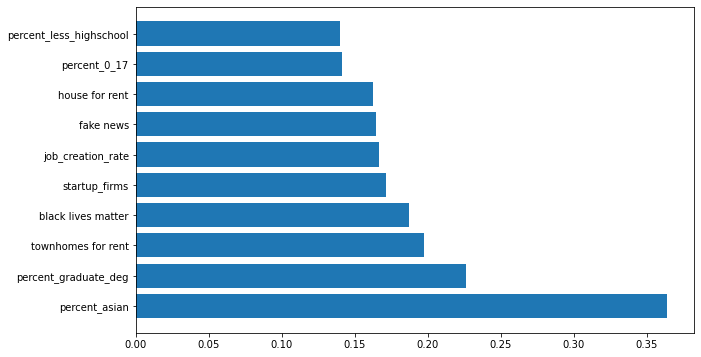


Got an mse at 0.0024 in epoch 31 and stopped training



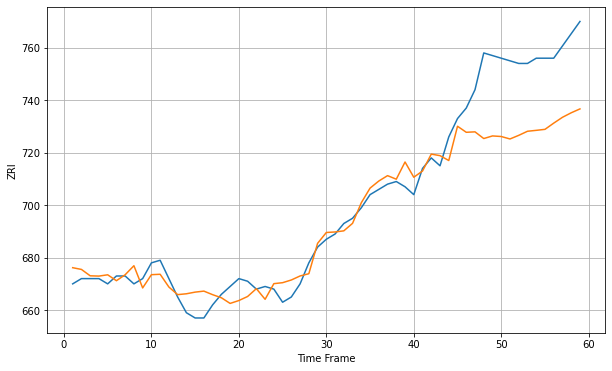

Wall time: 8.47 s
48235 5.442366232949951 28.95235645738213


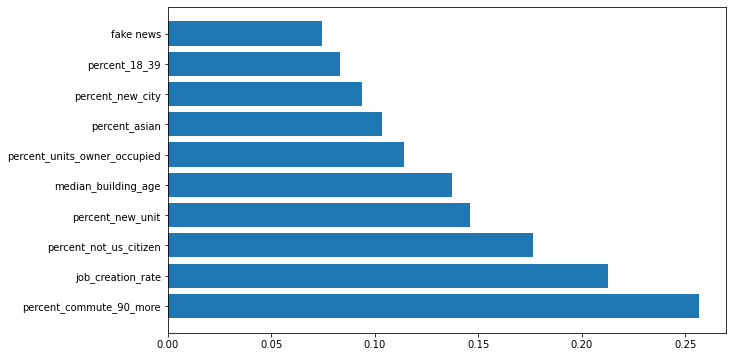


Got an mse at 0.0025 in epoch 81 and stopped training



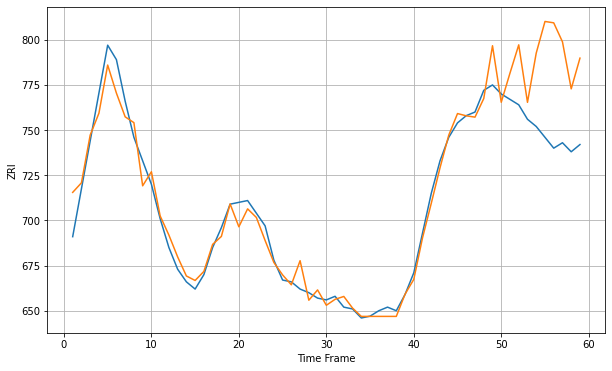

Wall time: 9.72 s
52001 7.319668211037062 39.909922822359654


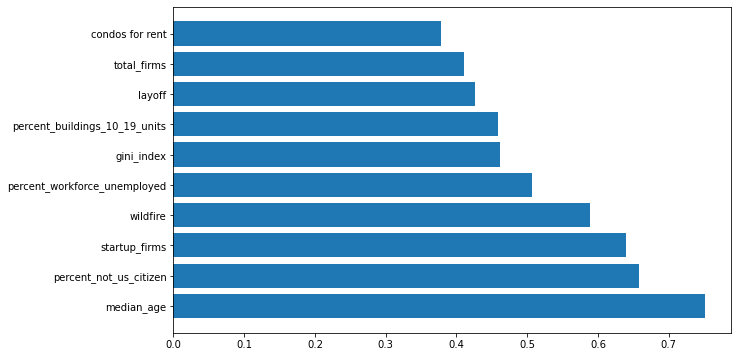


Got an mse at 0.0025 in epoch 36 and stopped training



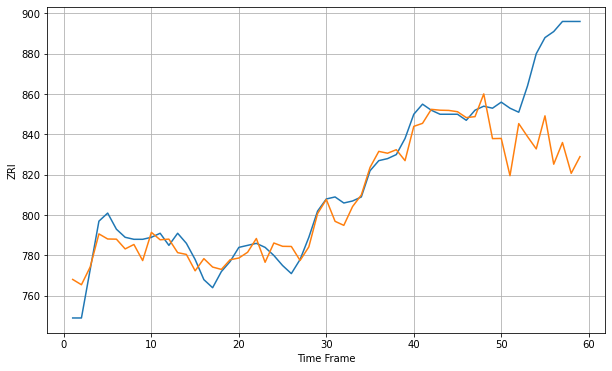

Wall time: 8.58 s
53140 7.19158386899007 44.89492467357809


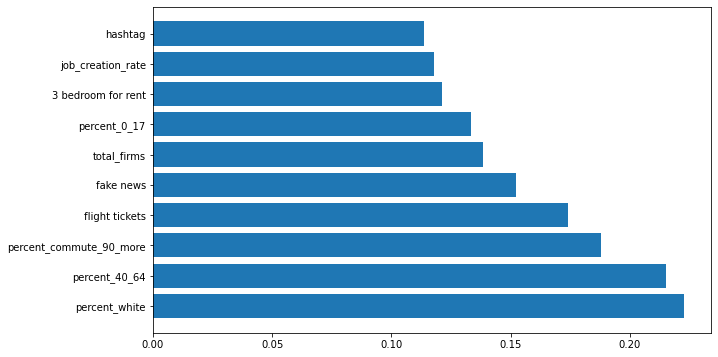


Got an mse at 0.0025 in epoch 39 and stopped training



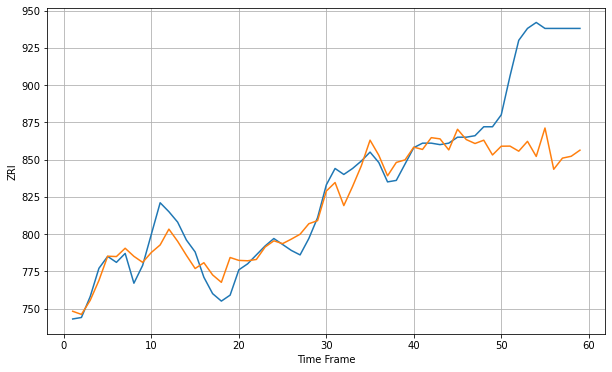

Wall time: 8.49 s
53143 9.770586427361424 69.20421613703823


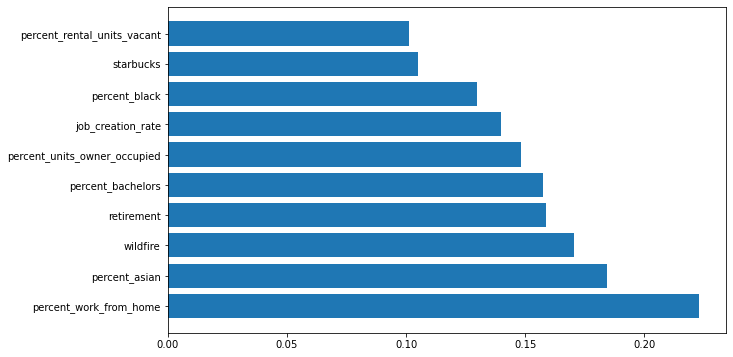


Got an mse at 0.0025 in epoch 20 and stopped training



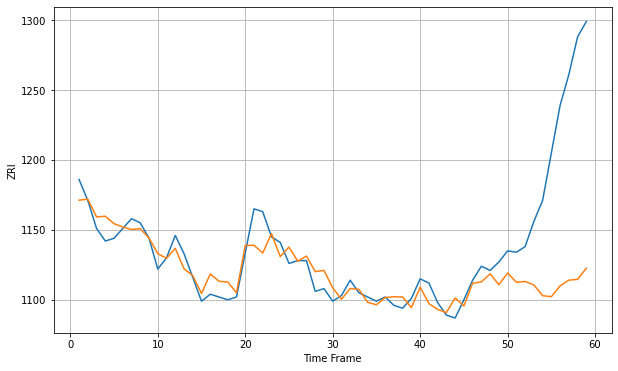

Wall time: 8.1 s
53202 10.098654944612102 99.2842217349595


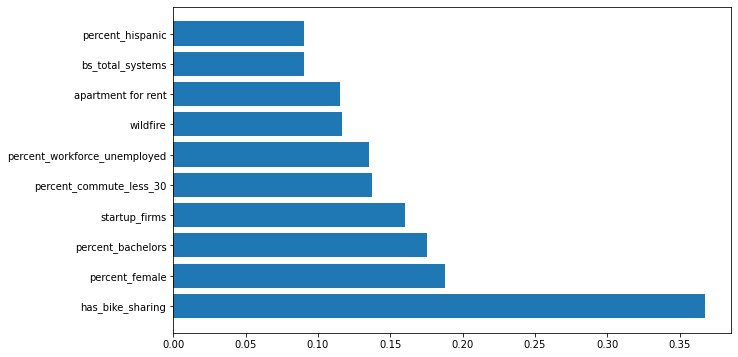


Got an mse at 0.0024 in epoch 31 and stopped training



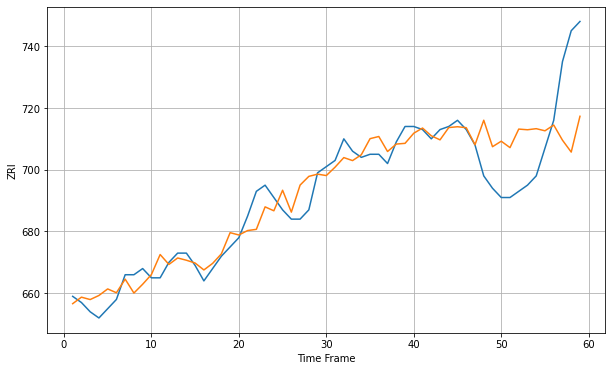

Wall time: 8.42 s
53204 4.61980888026004 20.872346214278817


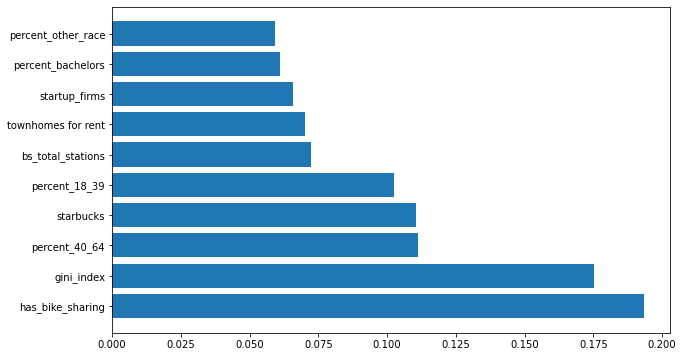


Got an mse at 0.0023 in epoch 18 and stopped training



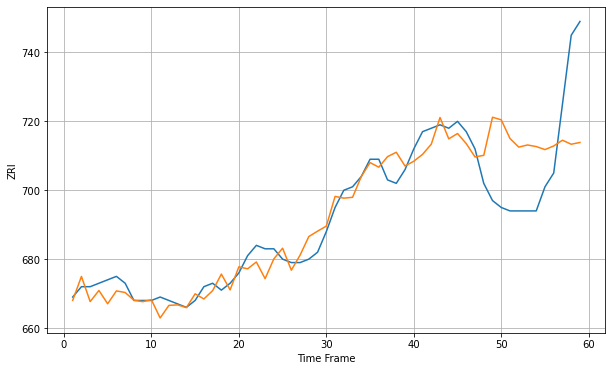

Wall time: 8.15 s
53206 3.8598600360555904 21.06042104090286


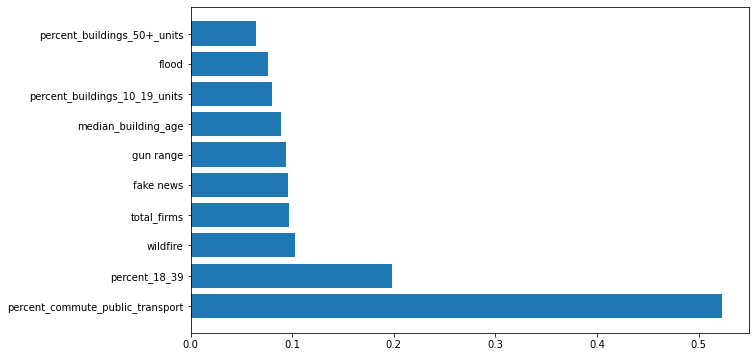


Got an mse at 0.0022 in epoch 23 and stopped training



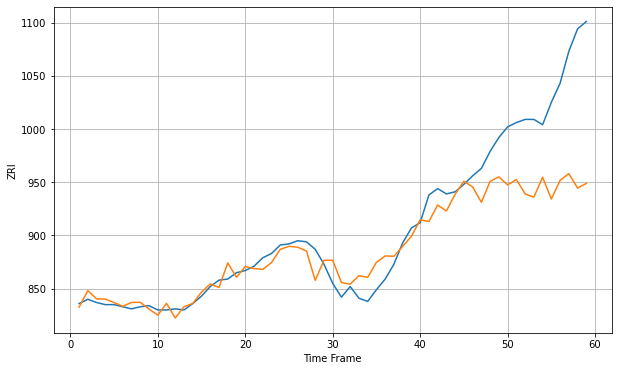

Wall time: 8.28 s
53207 12.203812066660547 89.4110336763156


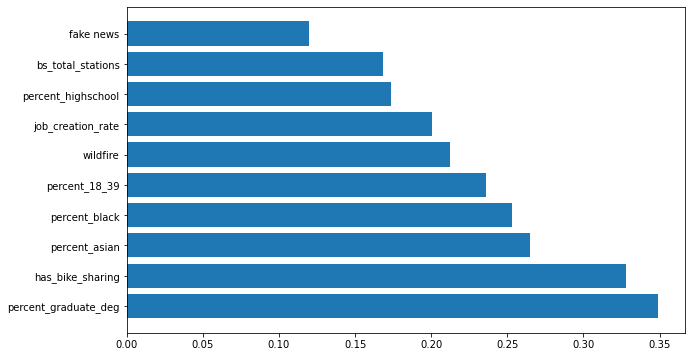


Got an mse at 0.0025 in epoch 24 and stopped training



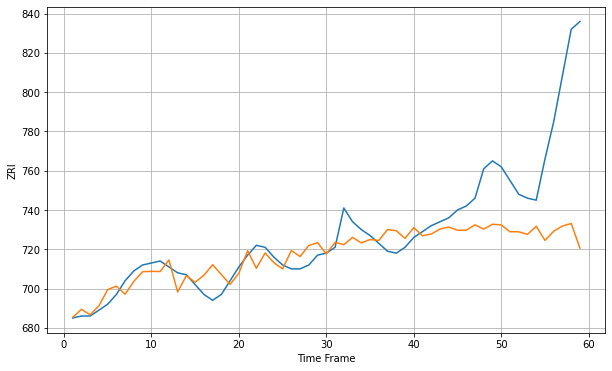

Wall time: 8.22 s
53208 7.391459247102284 56.46148504313448


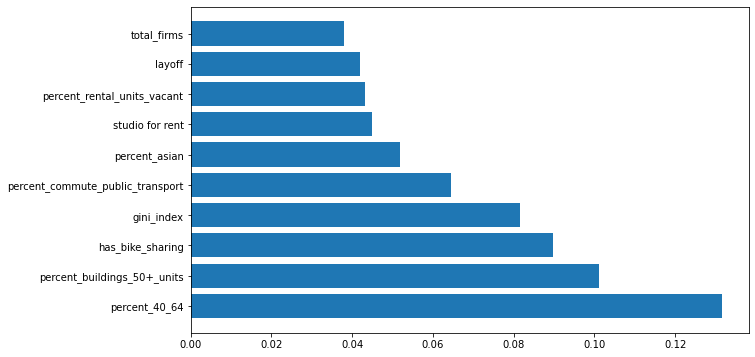


Got an mse at 0.0025 in epoch 55 and stopped training



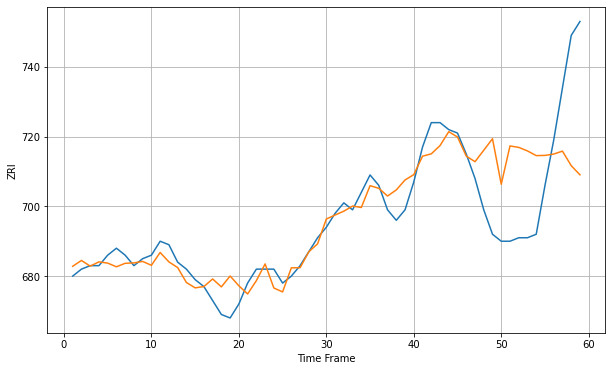

Wall time: 9.41 s
53209 4.196318859272337 25.167225075520182


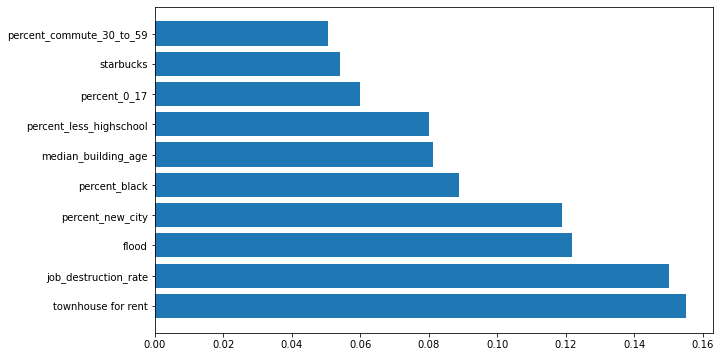


Got an mse at 0.0024 in epoch 56 and stopped training



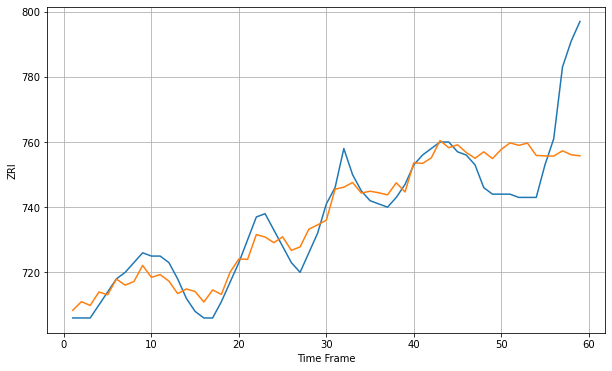

Wall time: 9.05 s
53210 4.489308174823804 20.391742065183927


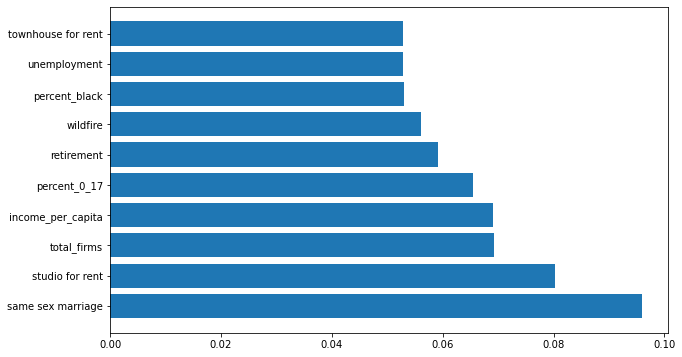


Got an mse at 0.0025 in epoch 65 and stopped training



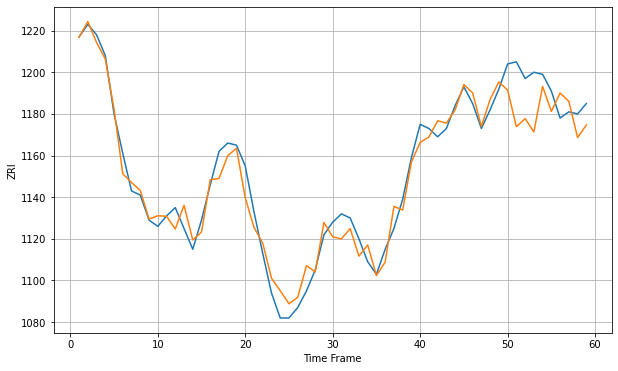

Wall time: 9.35 s
53211 6.799319974995605 15.520591004715163


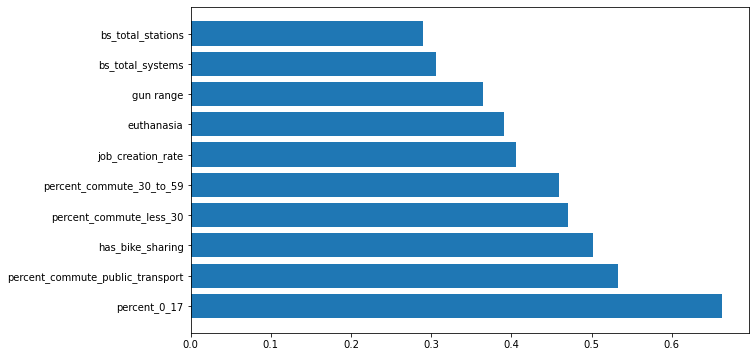


Got an mse at 0.0021 in epoch 14 and stopped training



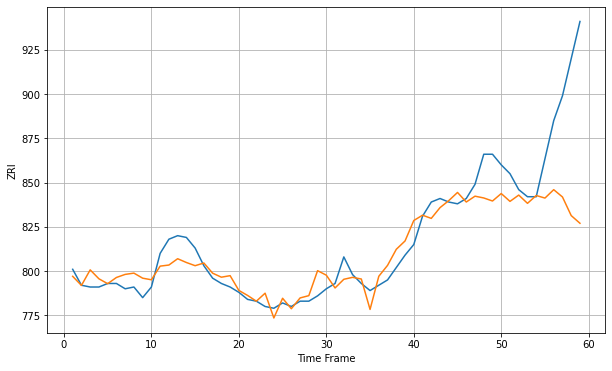

Wall time: 7.87 s
53212 7.322759942827227 48.28446849028645


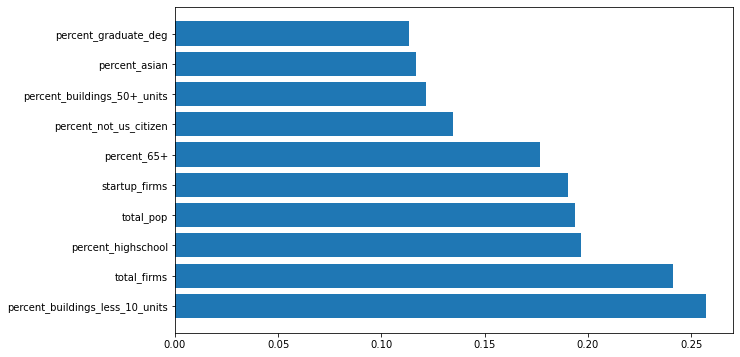


Got an mse at 0.0025 in epoch 32 and stopped training



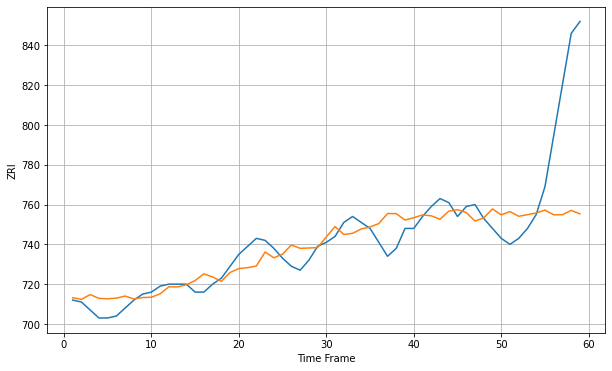

Wall time: 8.36 s
53215 7.3330856044443795 44.6659556211828


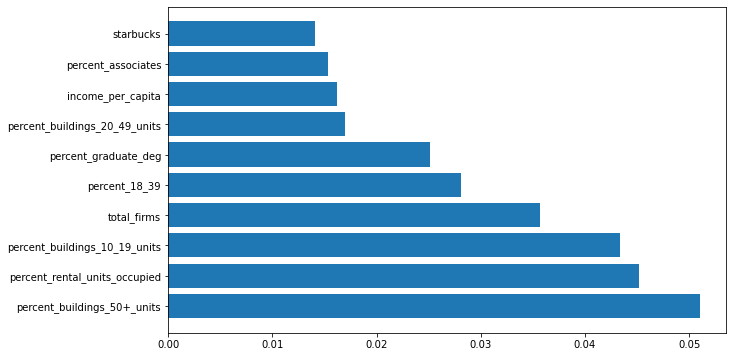


Got an mse at 0.0025 in epoch 20 and stopped training



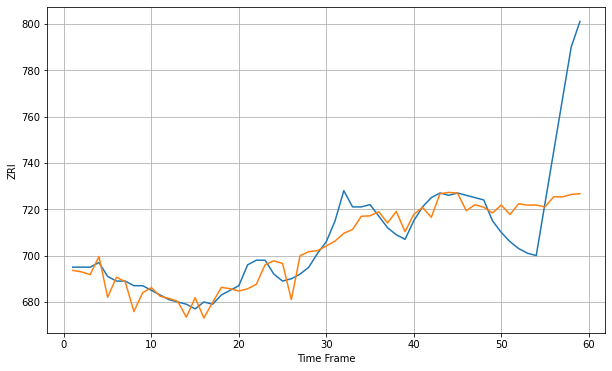

Wall time: 7.96 s
53216 5.957852562732362 33.30672214577571


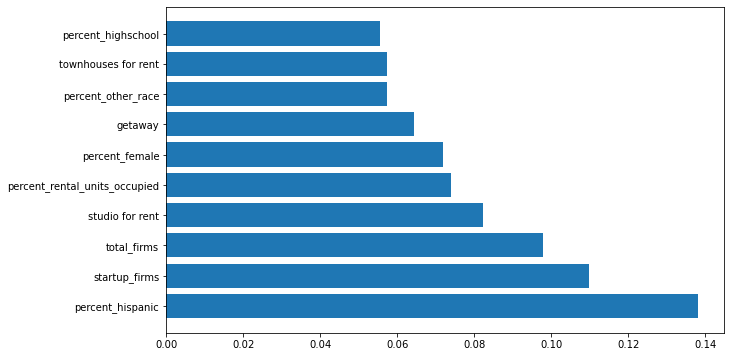


Got an mse at 0.0025 in epoch 24 and stopped training



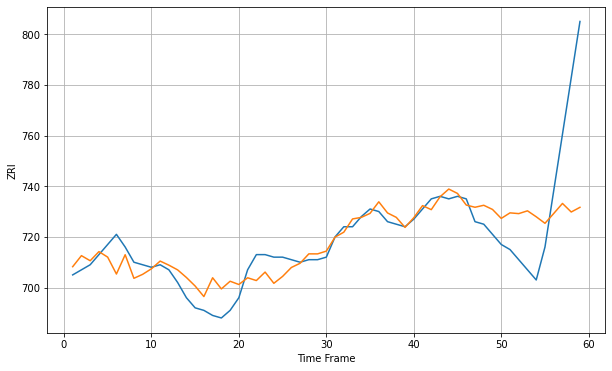

Wall time: 8.29 s
53218 5.775572006761631 30.354421880447752


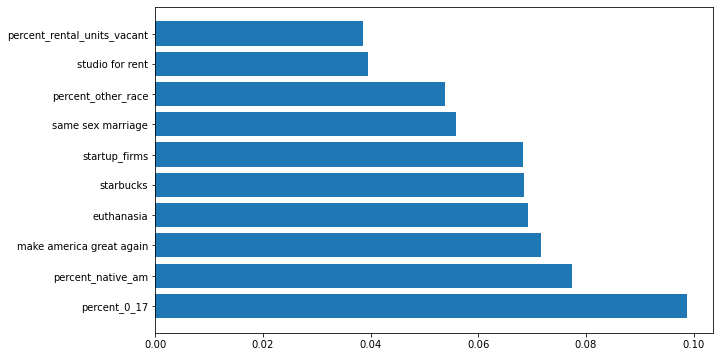


Got an mse at 0.0025 in epoch 176 and stopped training



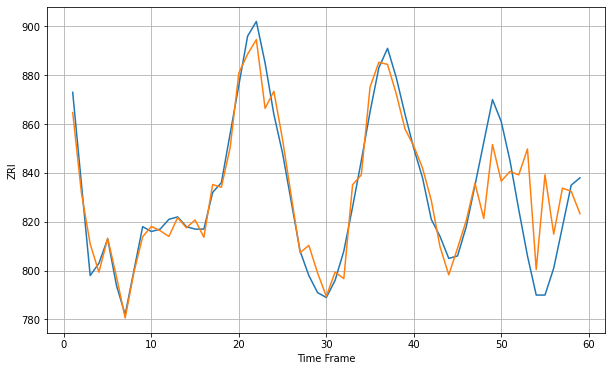

Wall time: 12.8 s
53403 6.339349763024713 24.563893961173434


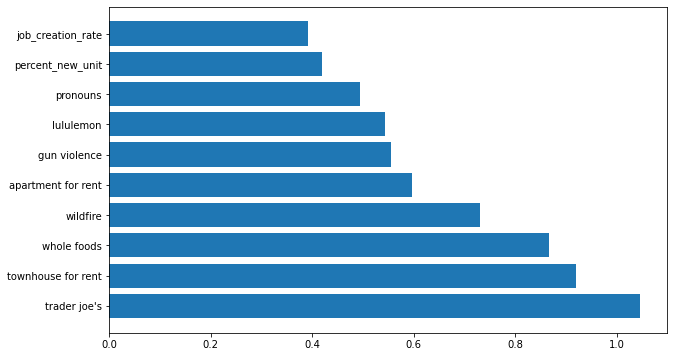


Got an mse at 0.0024 in epoch 33 and stopped training



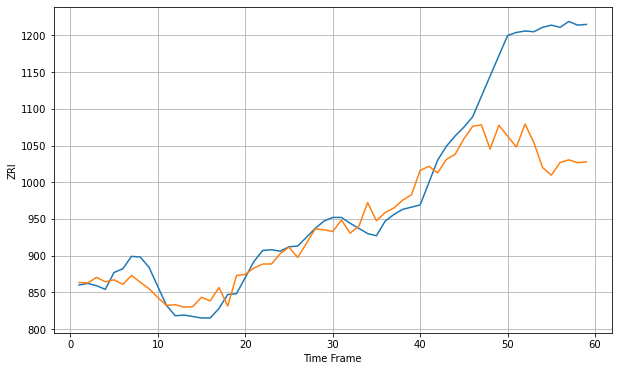

Wall time: 8.31 s
53590 19.489693445170715 163.02127340471154


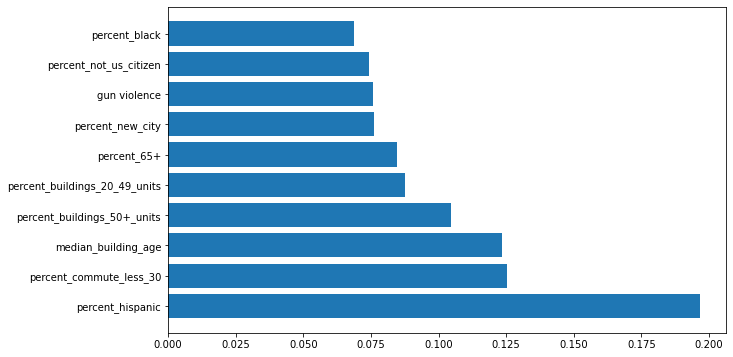


Got an mse at 0.0024 in epoch 111 and stopped training



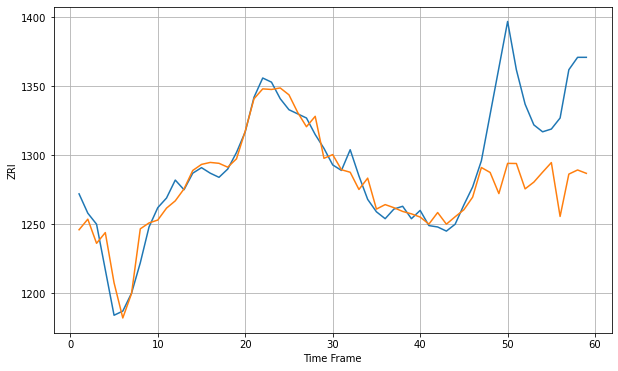

Wall time: 10.8 s
53703 10.288311173460468 68.79369501858457


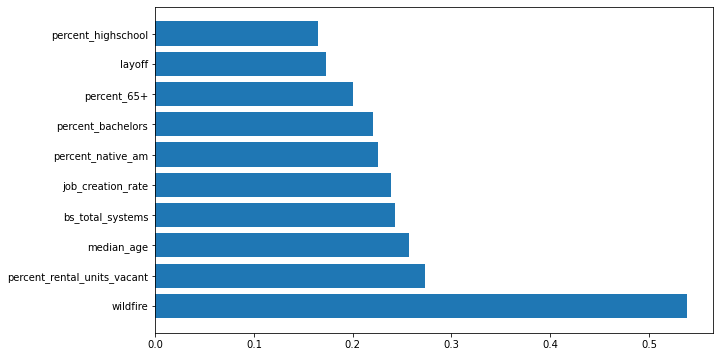


Got an mse at 0.0024 in epoch 24 and stopped training



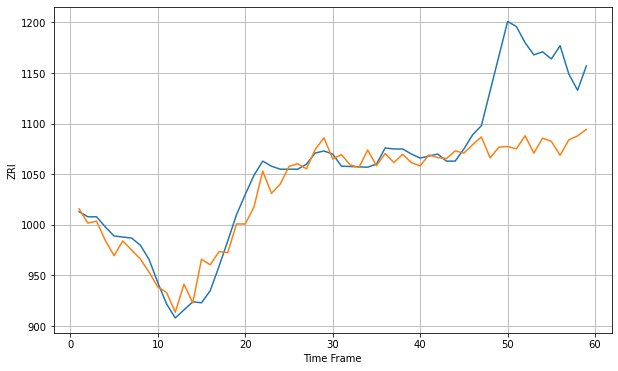

Wall time: 8.15 s
53704 13.950129543046772 89.45950826373027


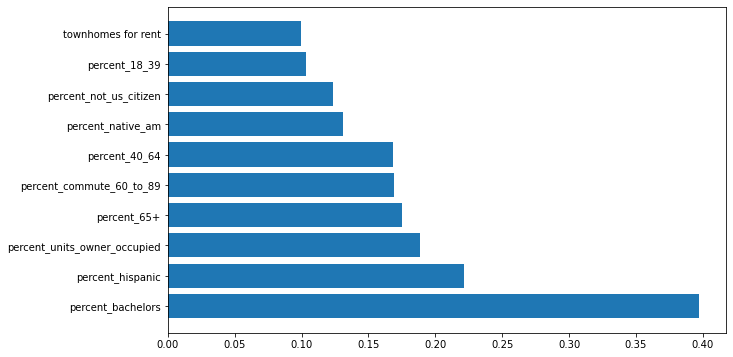


Got an mse at 0.0025 in epoch 86 and stopped training



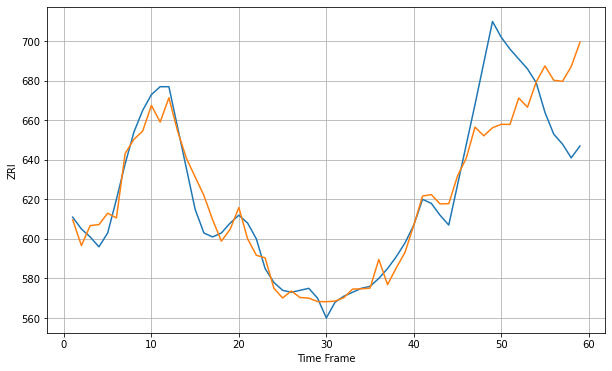

Wall time: 10.1 s
54220 7.448333232817655 36.04461483173853


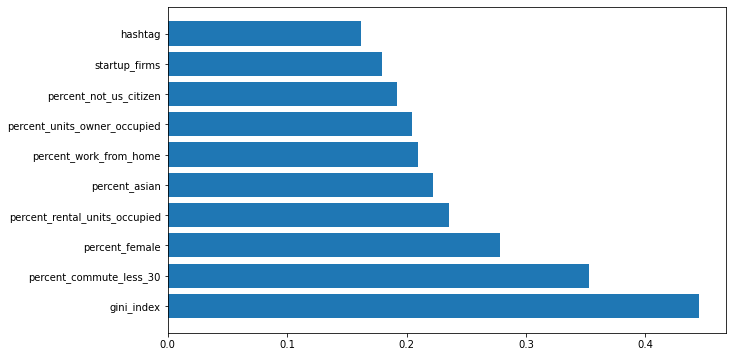


Got an mse at 0.0025 in epoch 193 and stopped training



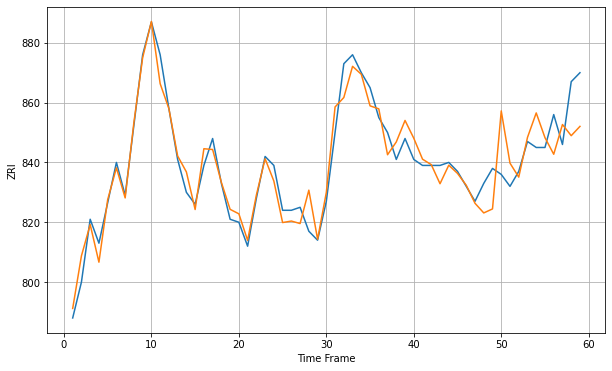

Wall time: 13.2 s
54601 4.873646351342389 12.28131807744448


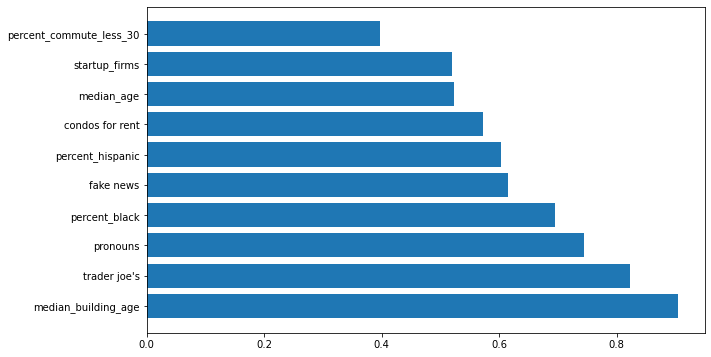


Got an mse at 0.0025 in epoch 95 and stopped training



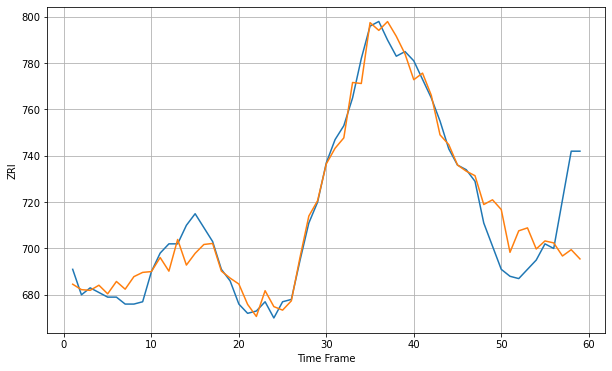

Wall time: 10.3 s
54901 6.324001324406825 23.4019083689972


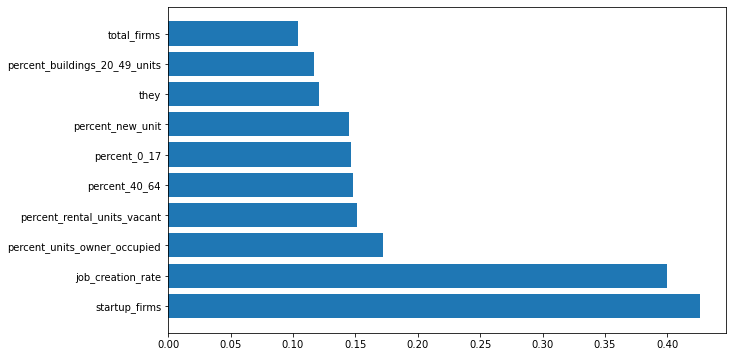


Got an mse at 0.0025 in epoch 72 and stopped training



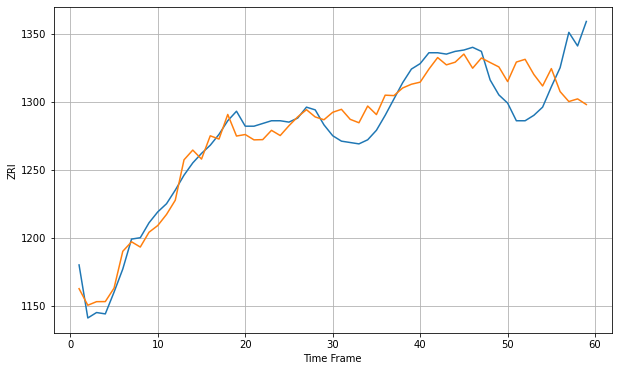

Wall time: 9.65 s
55101 10.726520211304003 34.405300666291545


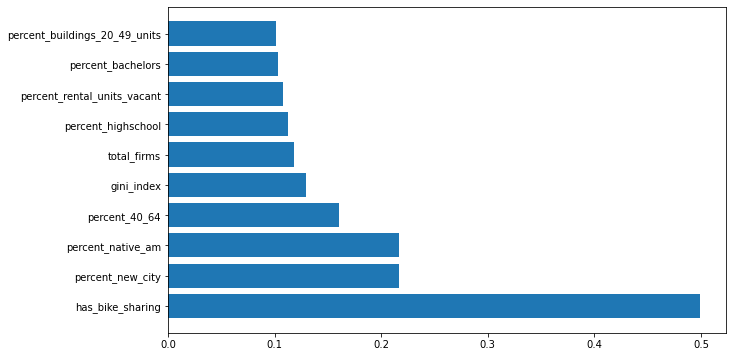


Got an mse at 0.0024 in epoch 38 and stopped training



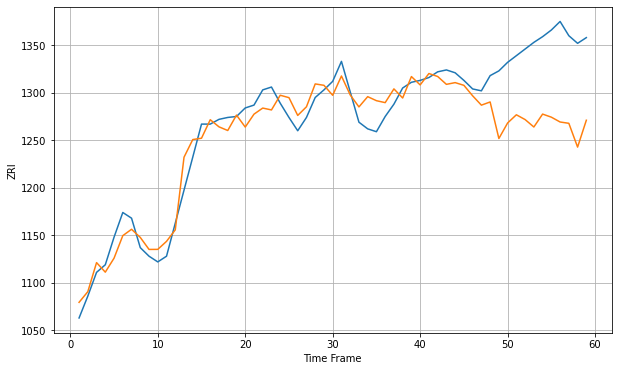

Wall time: 8.75 s
55104 15.413981096190644 82.3693481440939


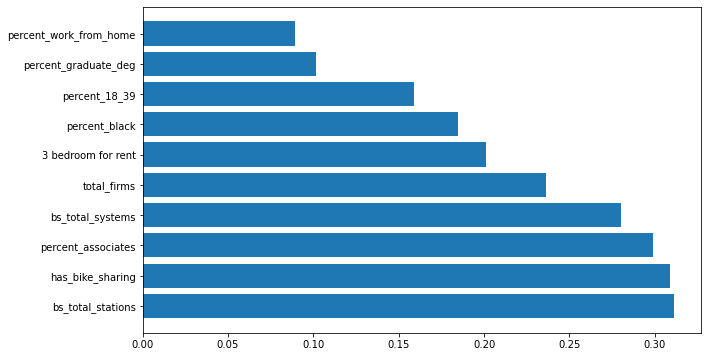


Got an mse at 0.0024 in epoch 18 and stopped training



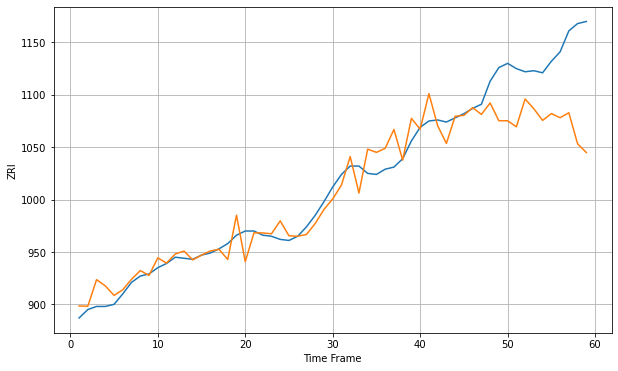

Wall time: 7.98 s
55106 13.655355441129688 67.41067392607656


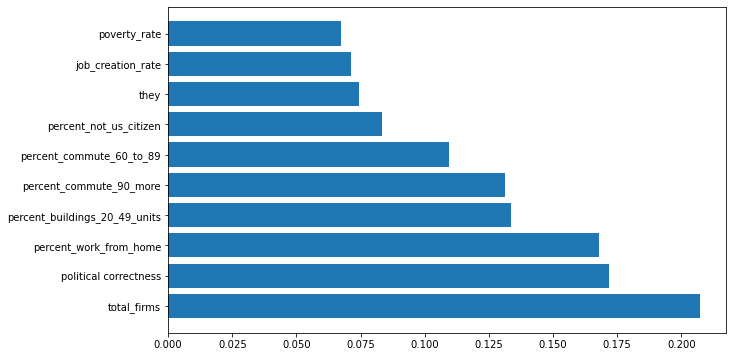


Got an mse at 0.0023 in epoch 26 and stopped training



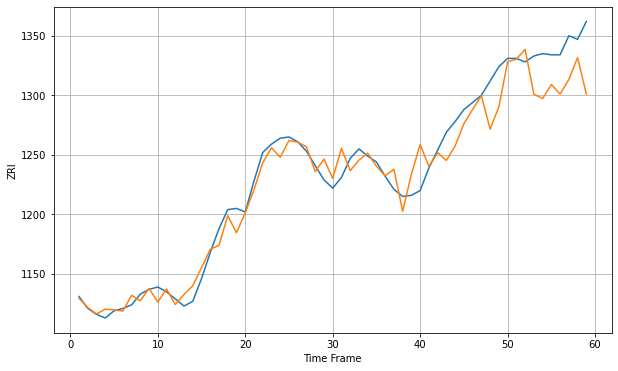

Wall time: 8.29 s
55306 11.649241784094261 32.07644221620138


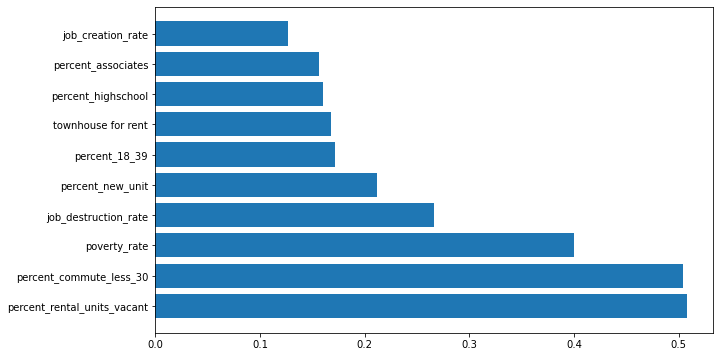


Got an mse at 0.0025 in epoch 71 and stopped training



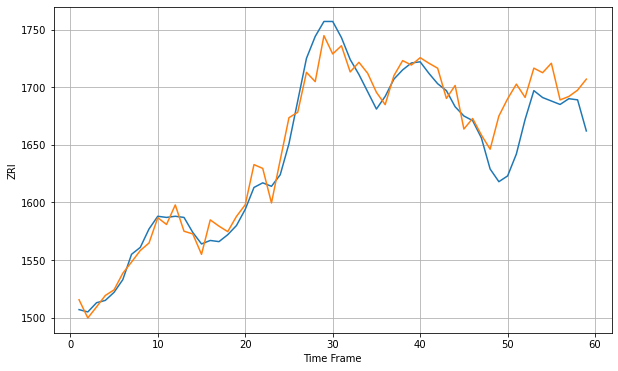

Wall time: 9.59 s
55401 12.322561792978798 36.61791252595294


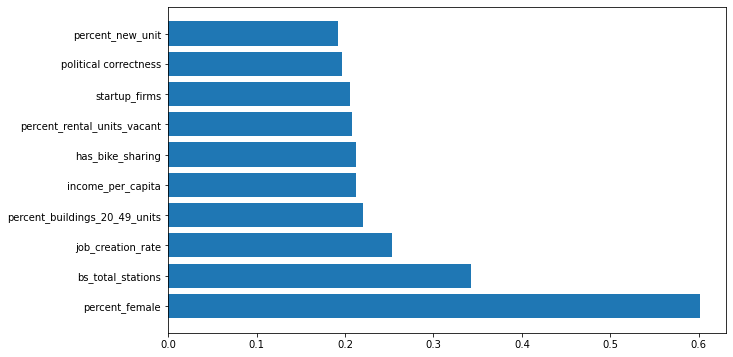


Got an mse at 0.0025 in epoch 83 and stopped training



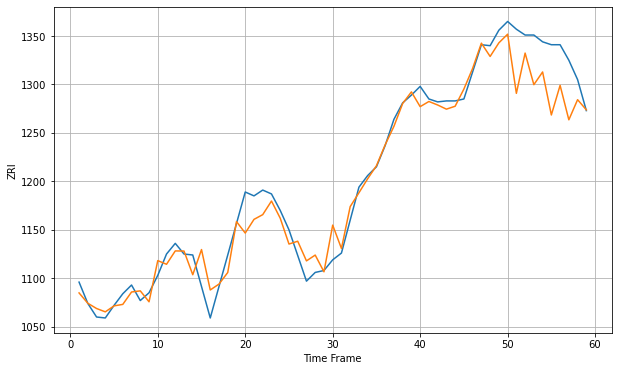

Wall time: 9.89 s
55403 15.072414098678086 40.83873205481611


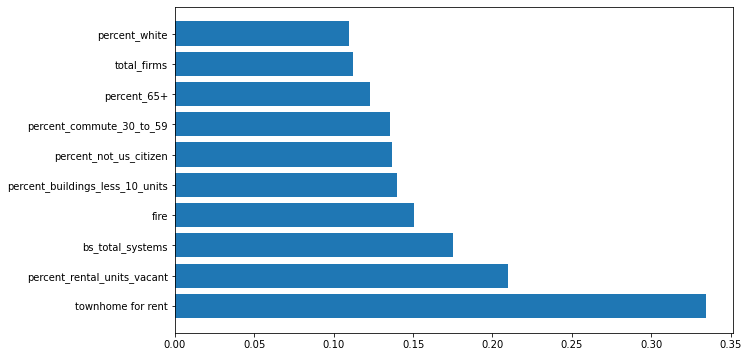


Got an mse at 0.0025 in epoch 74 and stopped training



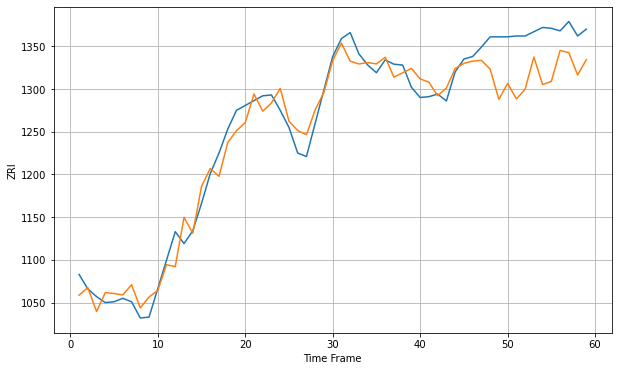

Wall time: 9.54 s
55404 17.01090209695186 52.81592467493646


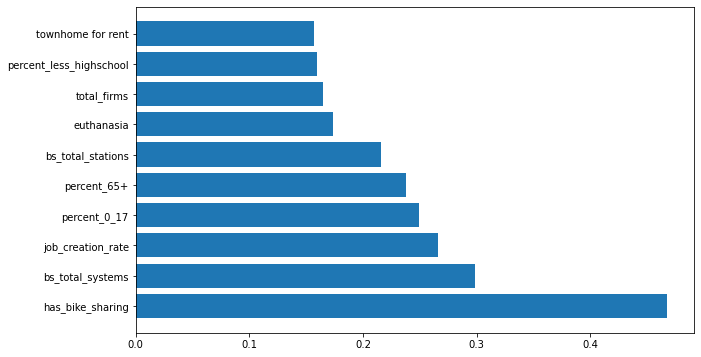


Got an mse at 0.0025 in epoch 64 and stopped training



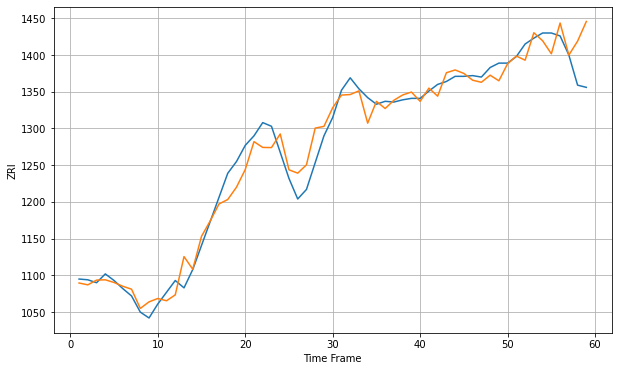

Wall time: 9.26 s
55407 19.188237265730283 34.25796864506125


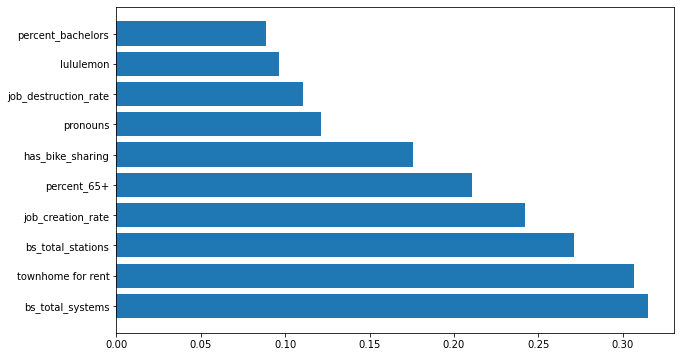


Got an mse at 0.0024 in epoch 33 and stopped training



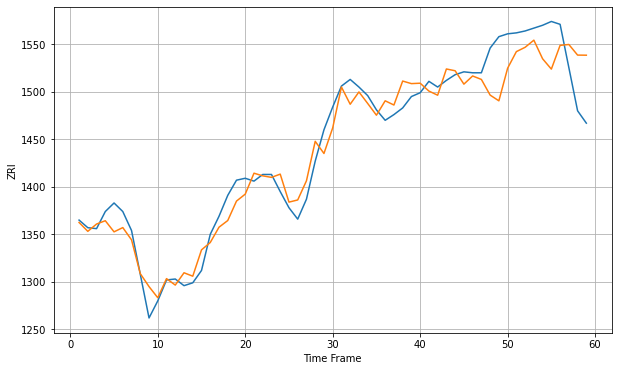

Wall time: 8.48 s
55408 15.100340476244671 43.34565285310906


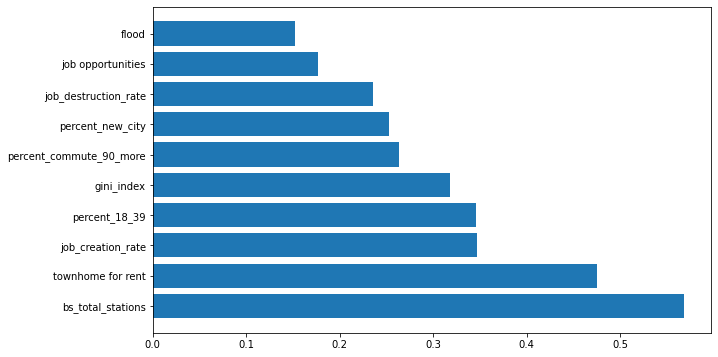


Got an mse at 0.0025 in epoch 76 and stopped training



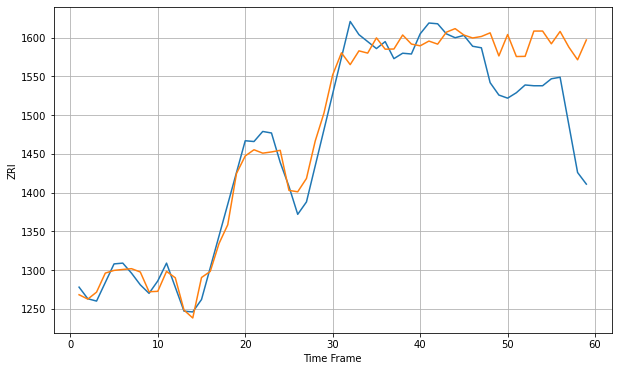

Wall time: 9.76 s
55411 18.36765156329825 90.54410498908346


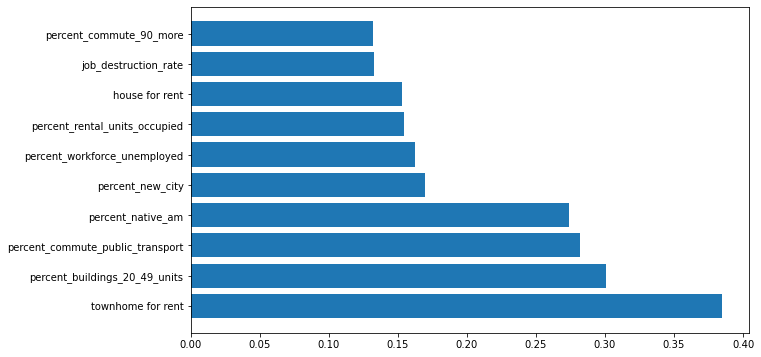


Got an mse at 0.0025 in epoch 33 and stopped training



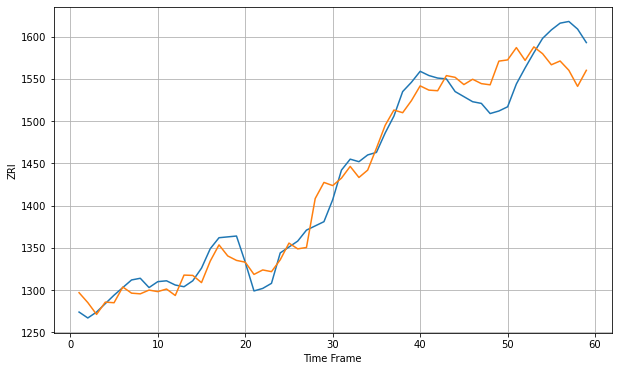

Wall time: 8.17 s
55413 17.1874970969093 43.554158802288


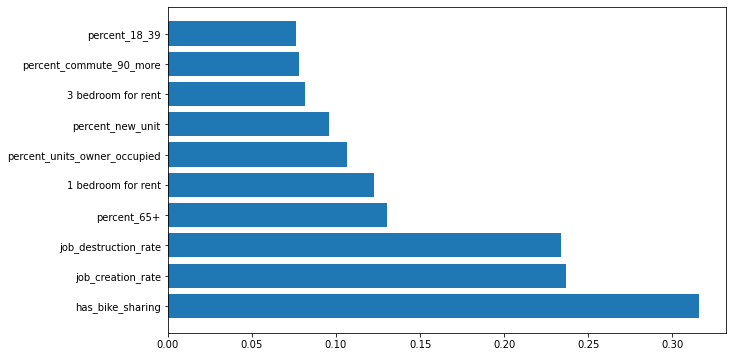


Got an mse at 0.0025 in epoch 50 and stopped training



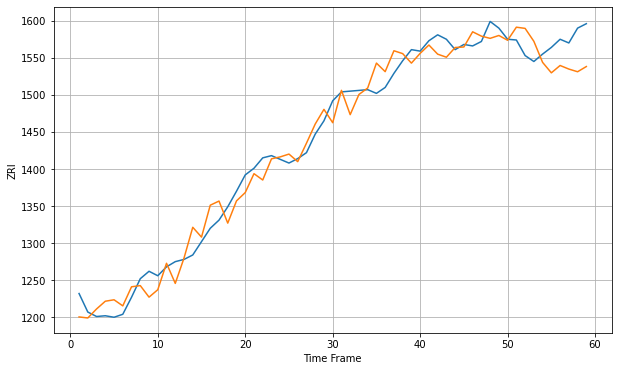

Wall time: 8.85 s
55414 19.64081488527118 33.66490834386562


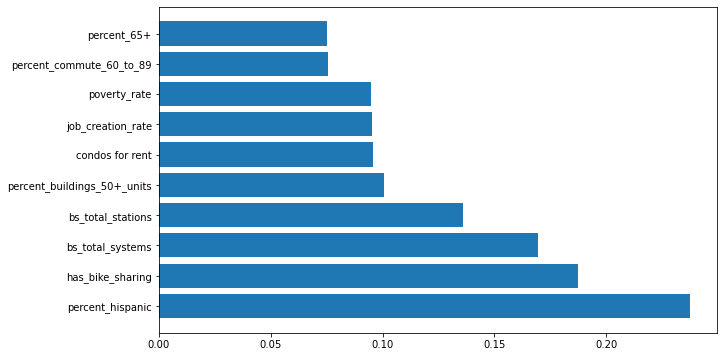


Got an mse at 0.0025 in epoch 52 and stopped training



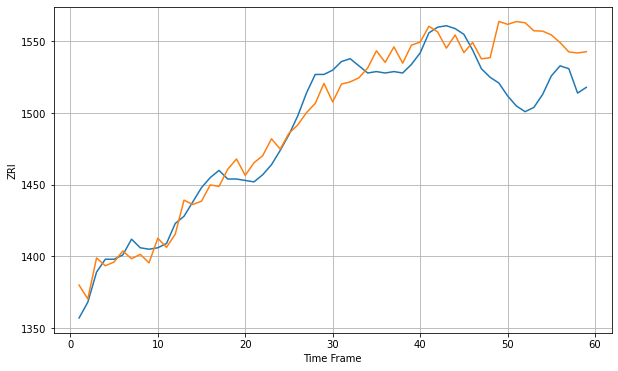

Wall time: 9.02 s
55416 10.83767104634523 40.09499950522788


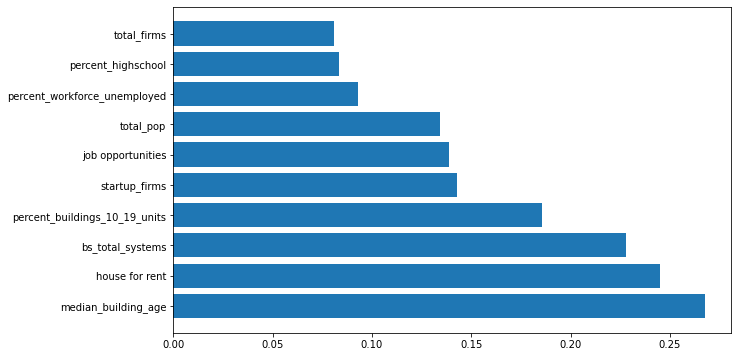


Got an mse at 0.0024 in epoch 35 and stopped training



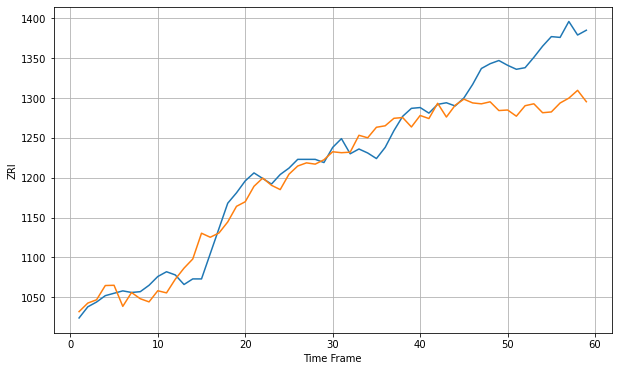

Wall time: 8.67 s
55418 18.733009296147408 72.6243184122833


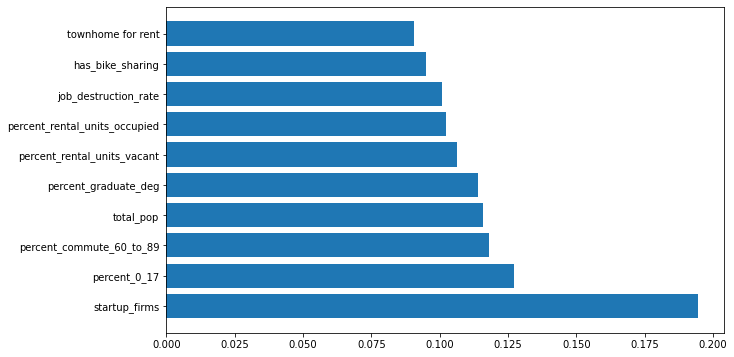


Got an mse at 0.0025 in epoch 72 and stopped training



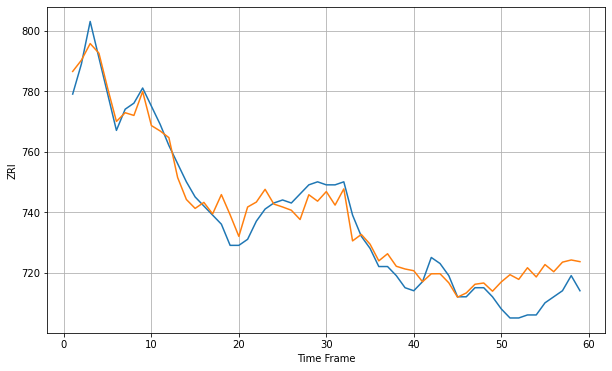

Wall time: 9.53 s
58103 4.83297080374519 10.373346851532396


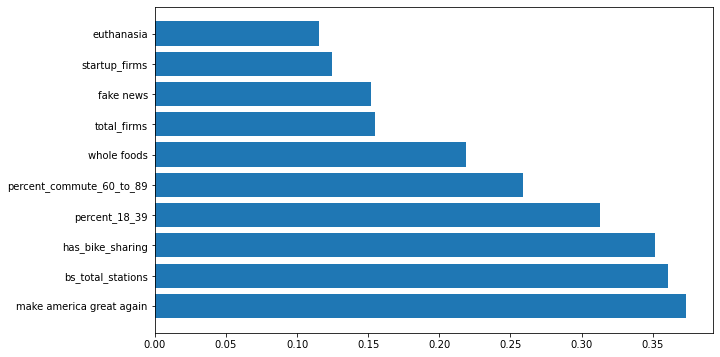


Got an mse at 0.0025 in epoch 62 and stopped training



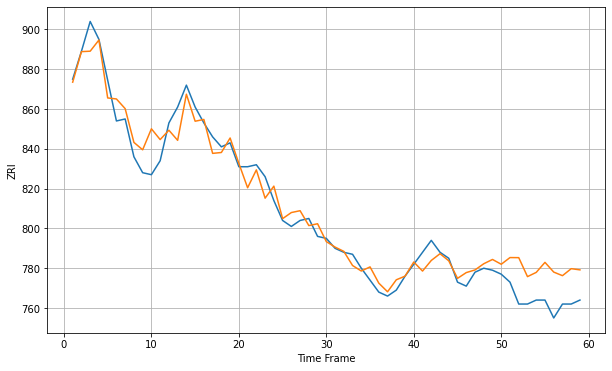

Wall time: 9.54 s
58104 7.33874243635685 15.217185055427512


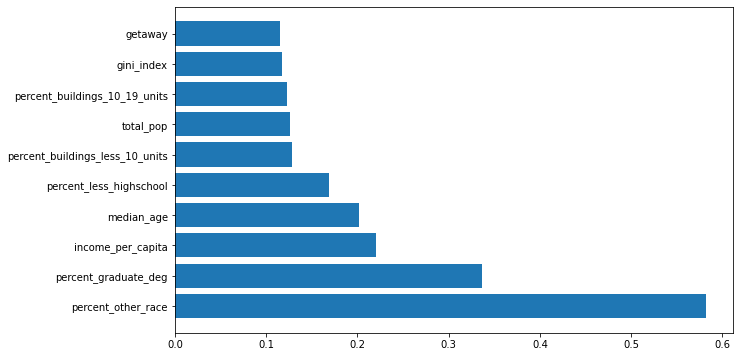


Got an mse at 0.0025 in epoch 166 and stopped training



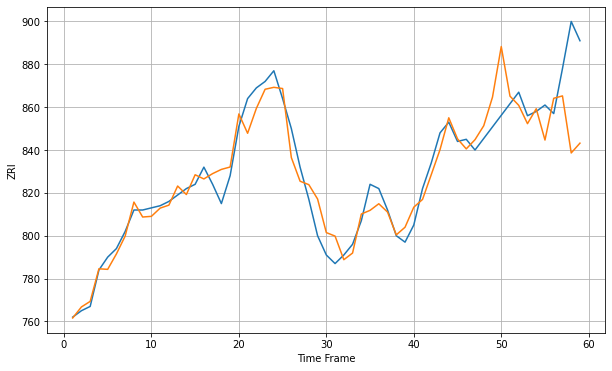

Wall time: 12.2 s
59601 7.001933326158113 25.584802699695906


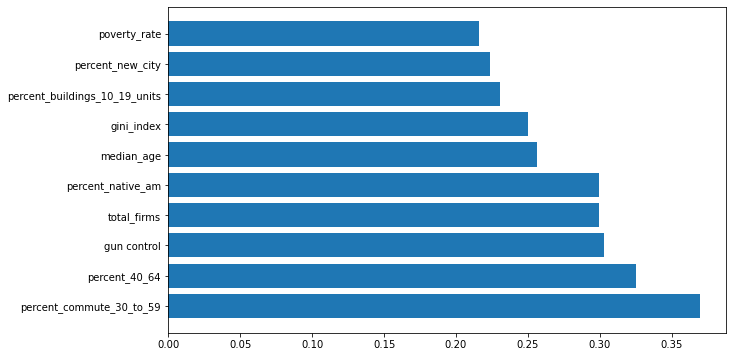


Got an mse at 0.0024 in epoch 41 and stopped training



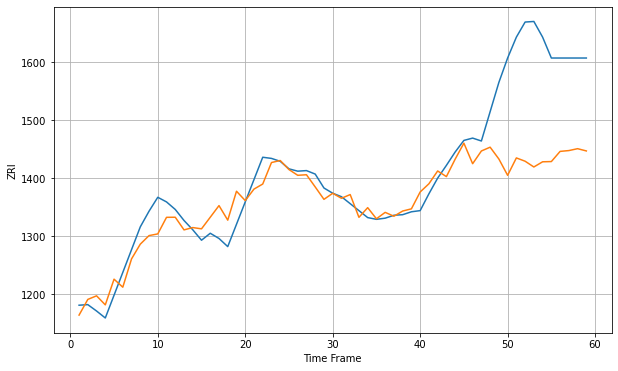

Wall time: 8.62 s
59718 24.955870607342142 183.75028283307526


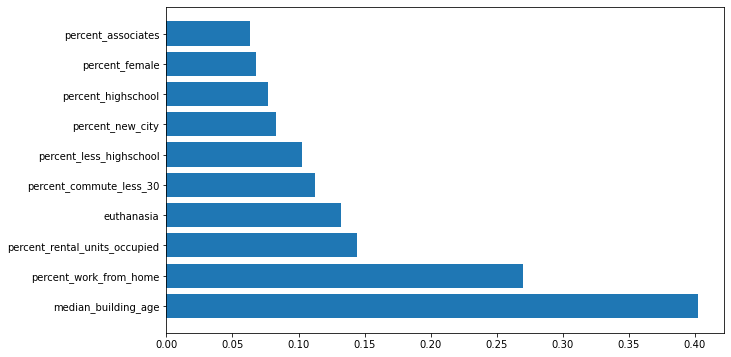


Got an mse at 0.0025 in epoch 49 and stopped training



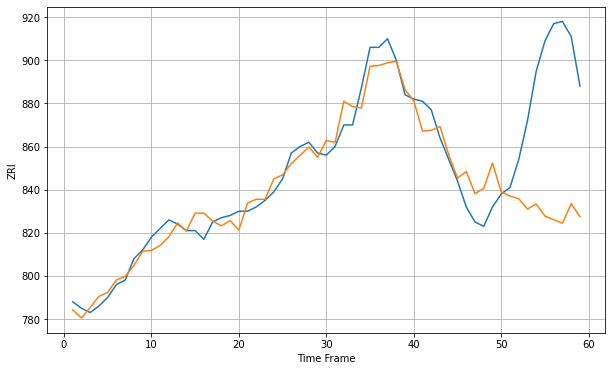

Wall time: 8.93 s
59801 6.5882667359809535 57.62228111436809


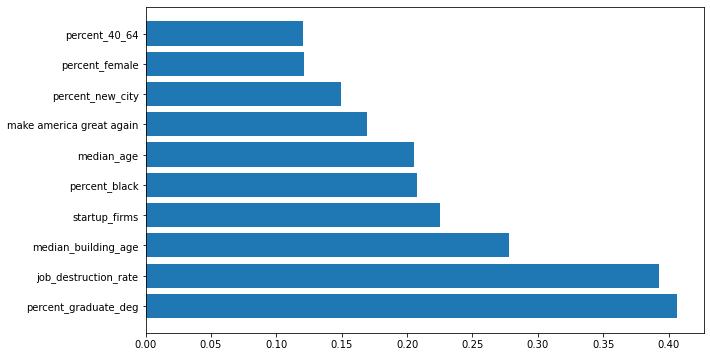


Got an mse at 0.0025 in epoch 60 and stopped training



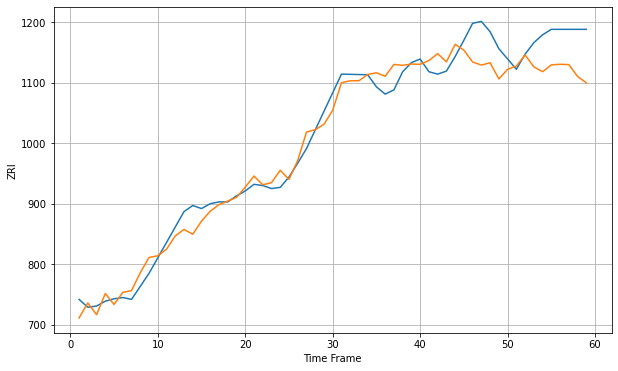

Wall time: 9.35 s
59901 23.37750074124601 53.845033157499444


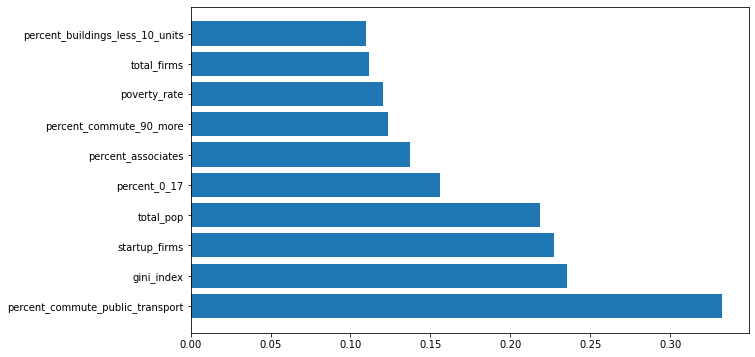


Got an mse at 0.0024 in epoch 78 and stopped training



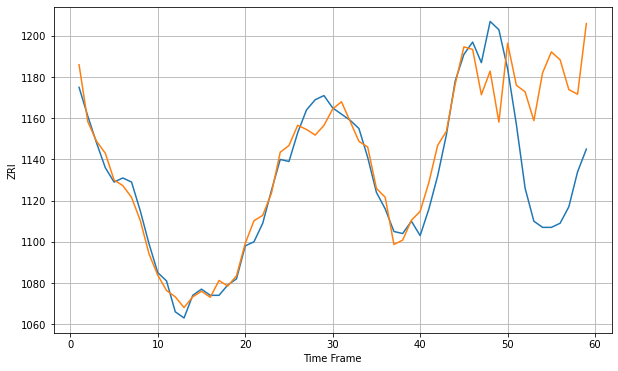

Wall time: 9.79 s
60085 6.900153843489981 54.20852855085124


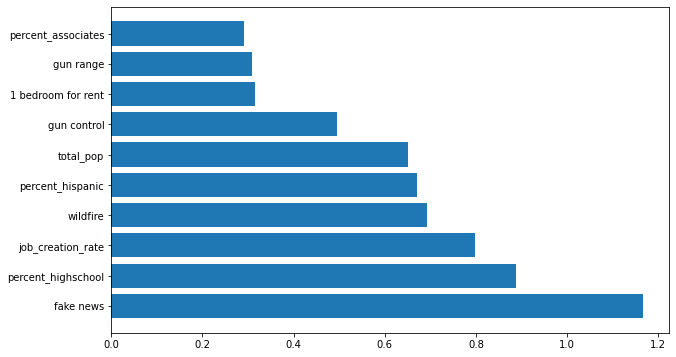


Got an mse at 0.0025 in epoch 122 and stopped training



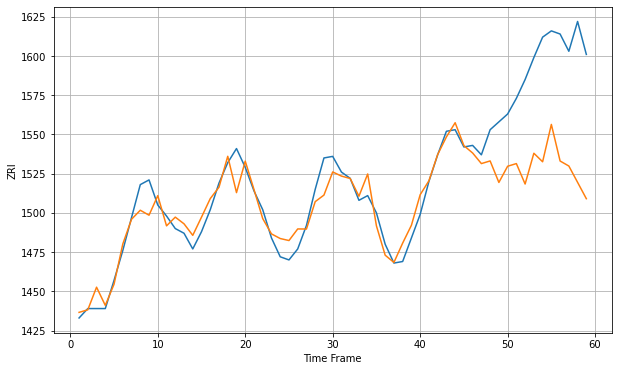

Wall time: 11.5 s
60201 9.44294491247749 66.84963439451721


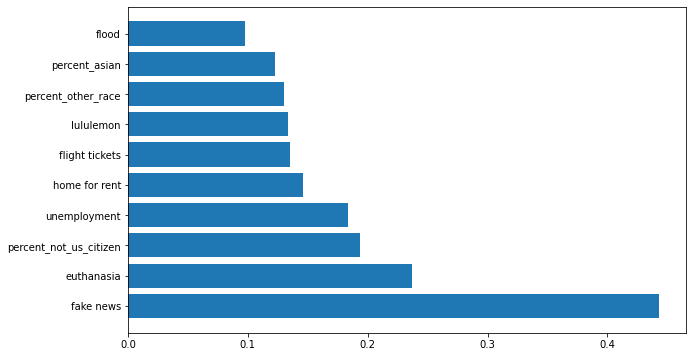


Got an mse at 0.0025 in epoch 141 and stopped training



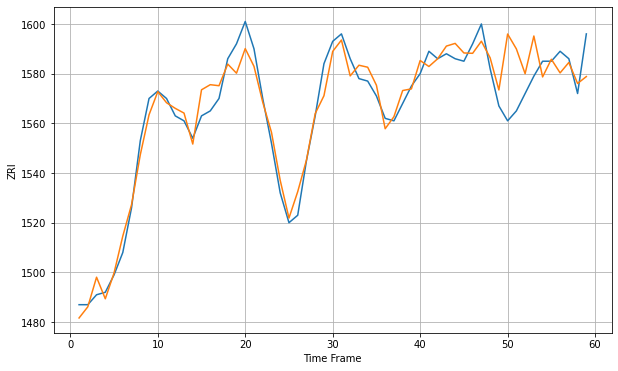

Wall time: 11.7 s
60202 5.625693333492081 14.88500850696271


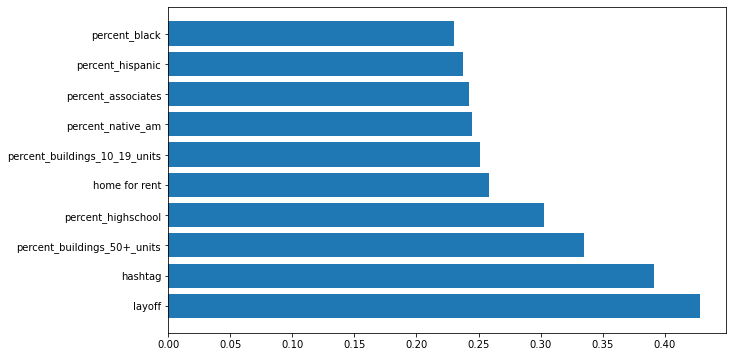


Got an mse at 0.0025 in epoch 96 and stopped training



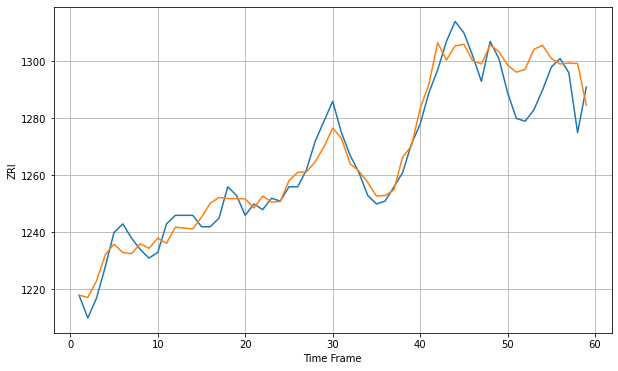

Wall time: 11.7 s
60402 5.140344355522024 13.041248220009258


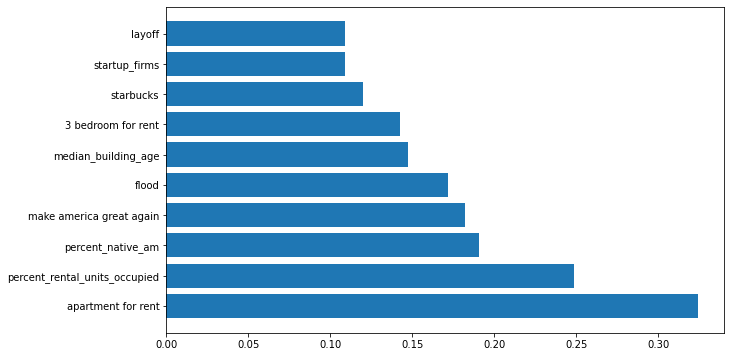


Got an mse at 0.0025 in epoch 64 and stopped training



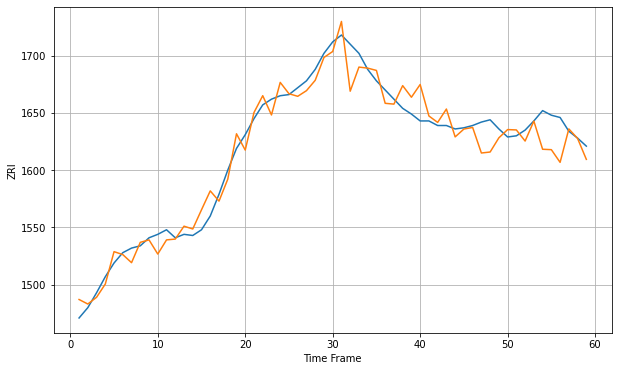

Wall time: 10.6 s
60540 12.925109560728457 19.840462990314748


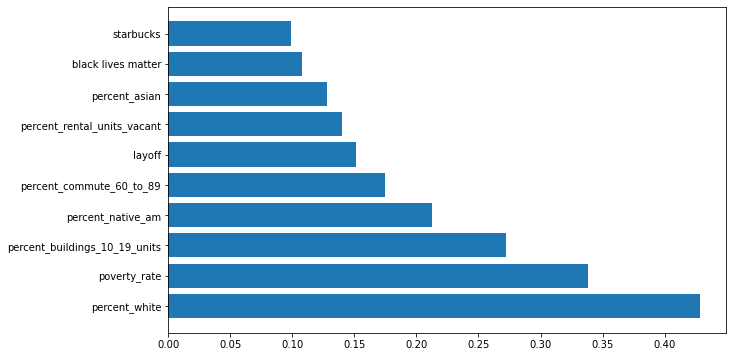


Got an mse at 0.0024 in epoch 80 and stopped training



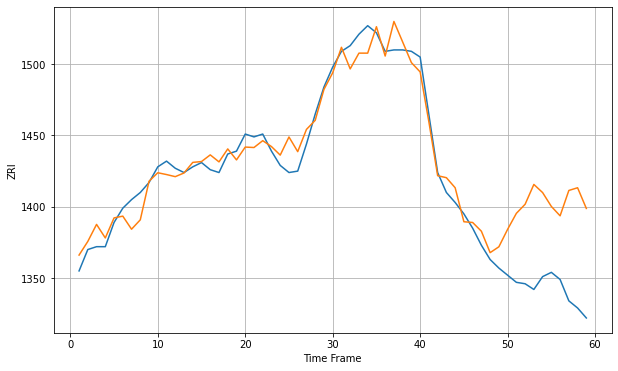

Wall time: 10.9 s
60563 9.953337228293888 56.84091162546491


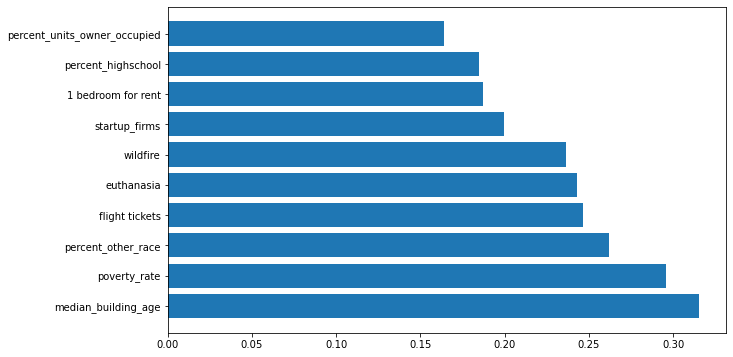


Got an mse at 0.0025 in epoch 103 and stopped training



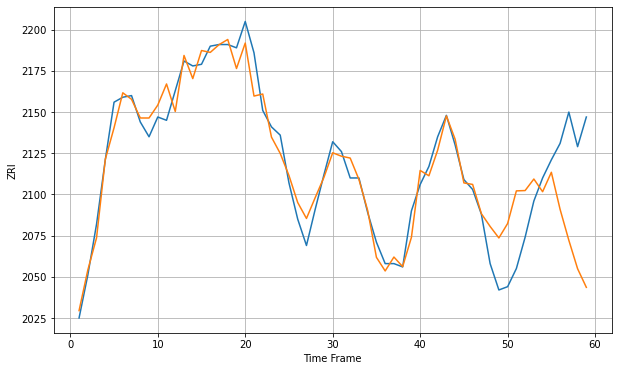

Wall time: 11.2 s
60601 9.053872058813827 50.13118725486191


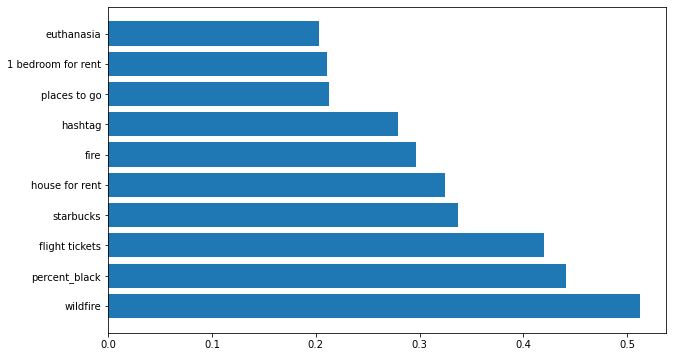


Got an mse at 0.0025 in epoch 91 and stopped training



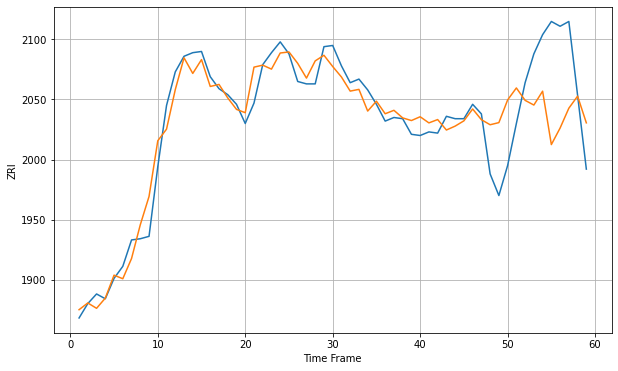

Wall time: 10.6 s
60605 12.125874678991181 56.19155019576477


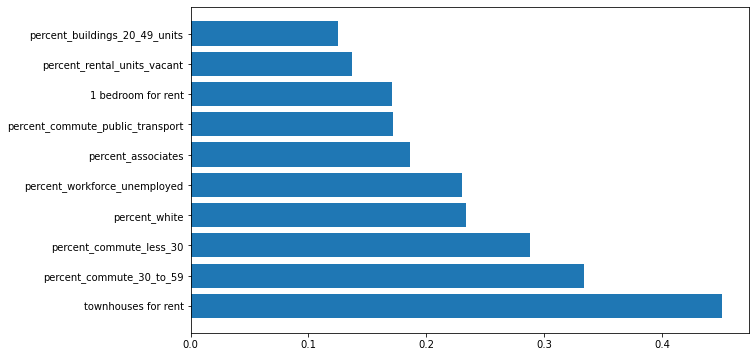


Got an mse at 0.0024 in epoch 136 and stopped training



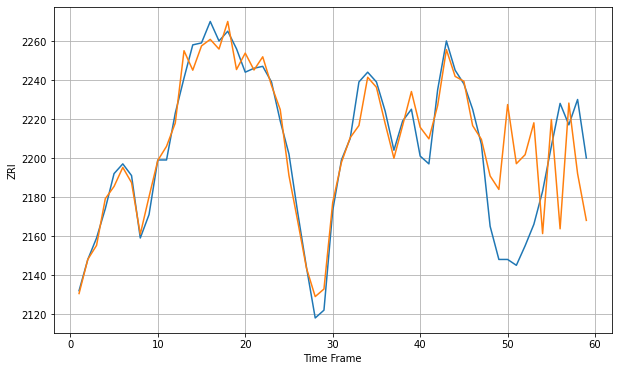

Wall time: 11.9 s
60606 7.49875192629271 44.015357054986595


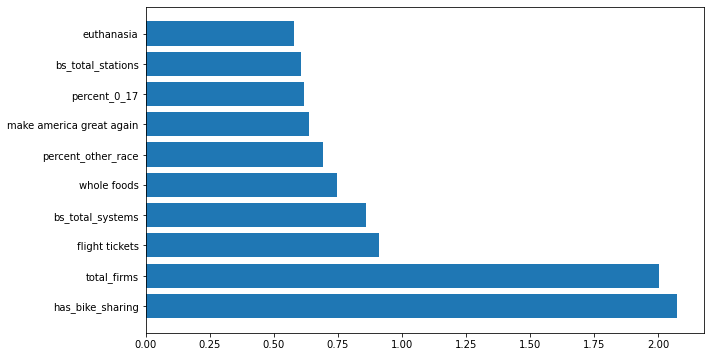


Got an mse at 0.0025 in epoch 117 and stopped training



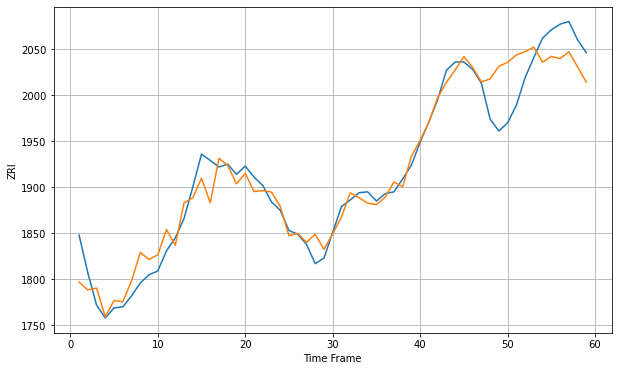

Wall time: 11.5 s
60607 15.948234440307095 41.79444260967075


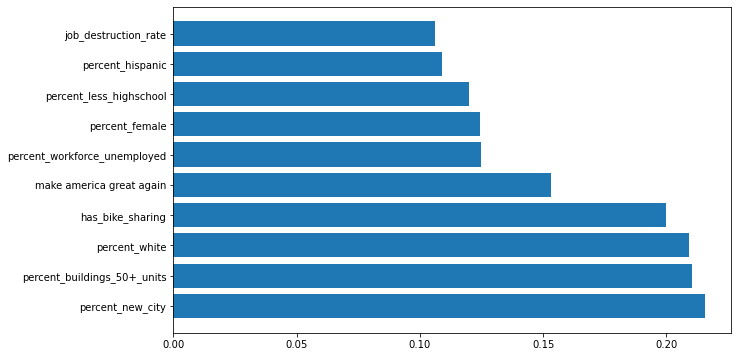


Got an mse at 0.0024 in epoch 61 and stopped training



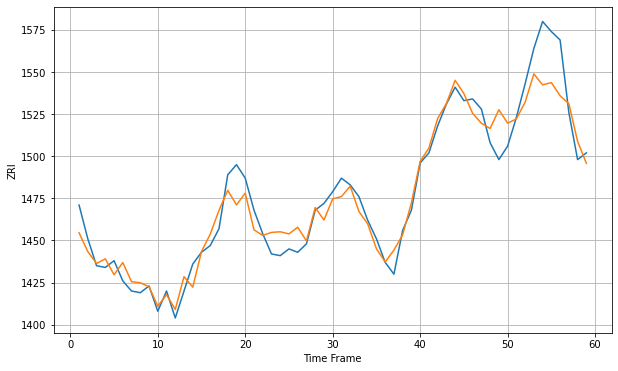

Wall time: 9.48 s
60608 8.516005067242183 20.599497489328403


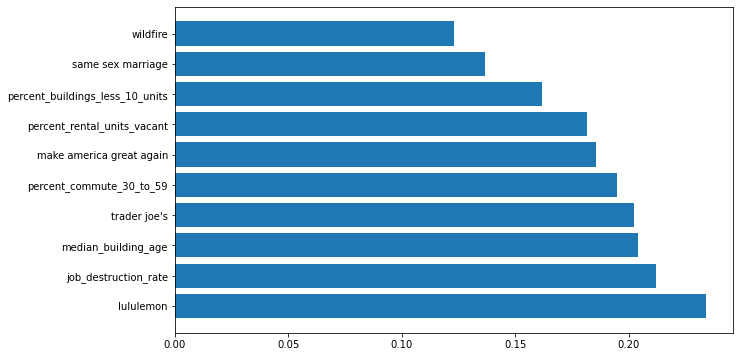


Got an mse at 0.0024 in epoch 49 and stopped training



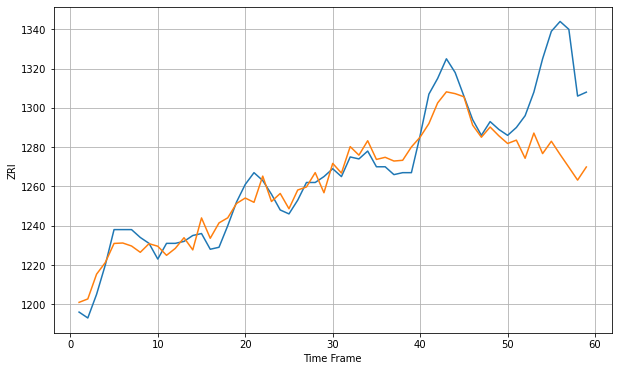

Wall time: 9.36 s
60609 7.307771284718304 40.054192390099274


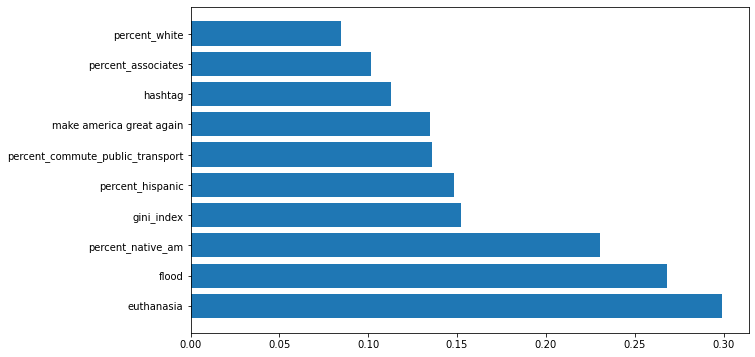


Got an mse at 0.0025 in epoch 103 and stopped training



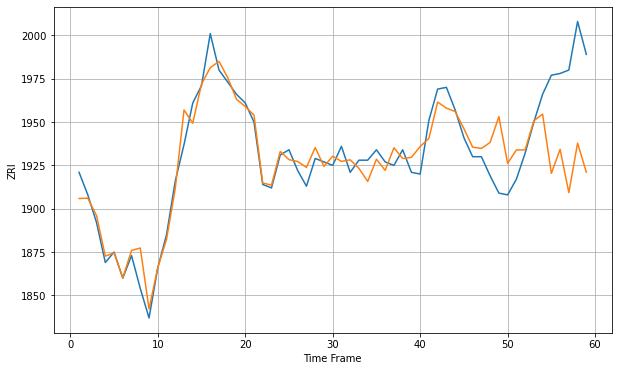

Wall time: 10.8 s
60610 8.391957384640277 43.515344115699286


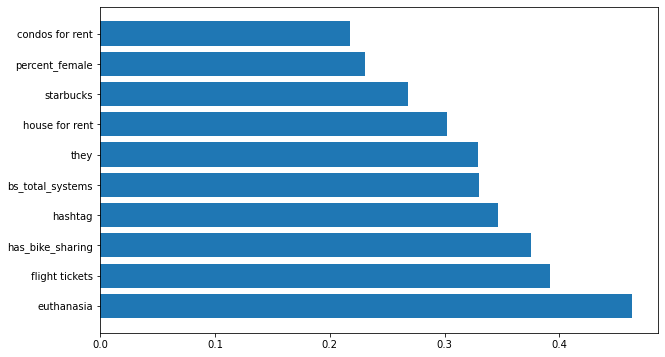


Got an mse at 0.0024 in epoch 106 and stopped training



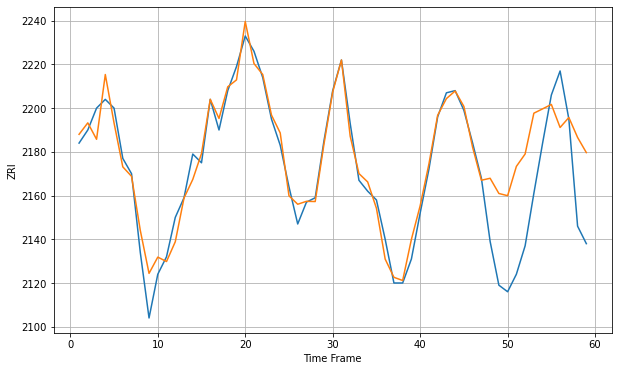

Wall time: 10.8 s
60611 6.269874397511695 34.62466908730337


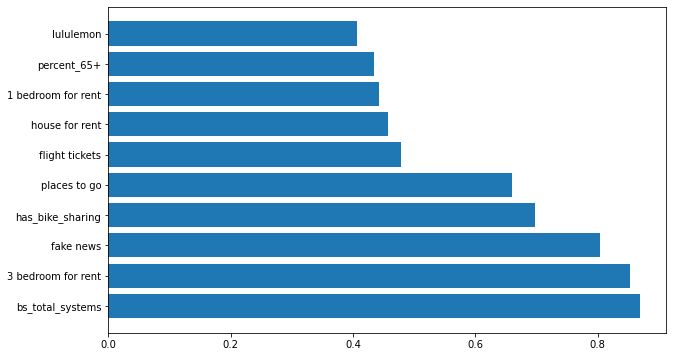


Got an mse at 0.0024 in epoch 32 and stopped training



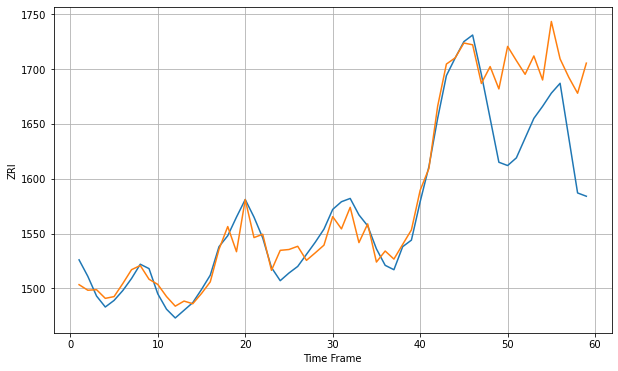

Wall time: 8.86 s
60612 12.309857842460021 73.26072464730481


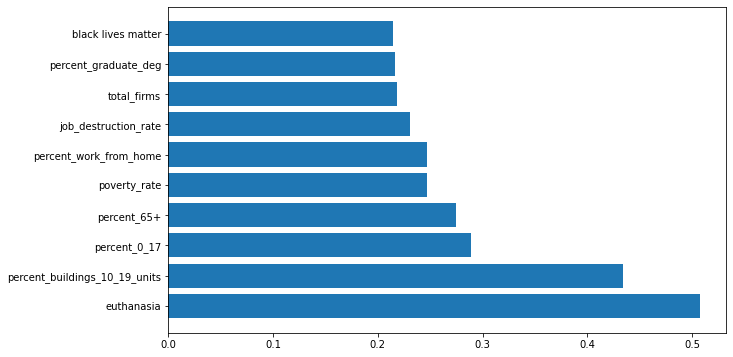


Got an mse at 0.0024 in epoch 66 and stopped training



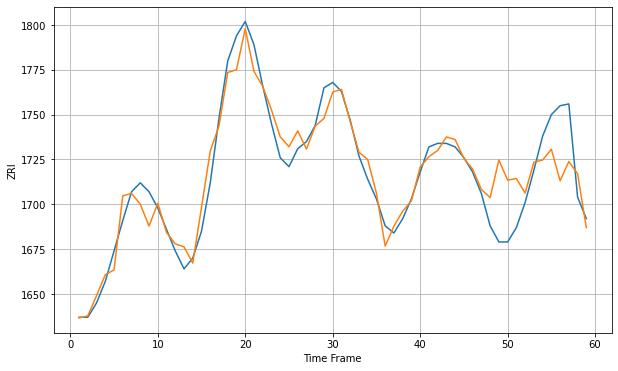

Wall time: 9.75 s
60613 8.399612995169466 25.584051336841554


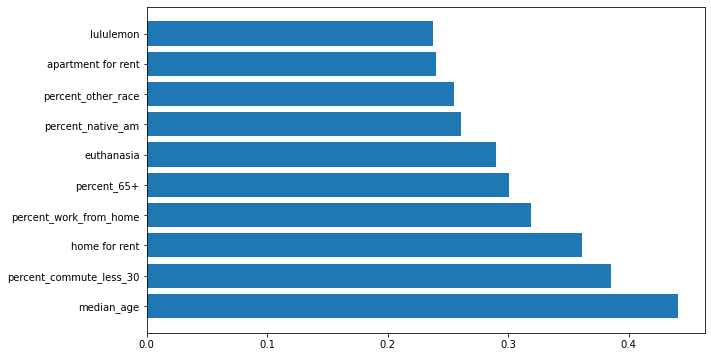


Got an mse at 0.0025 in epoch 38 and stopped training



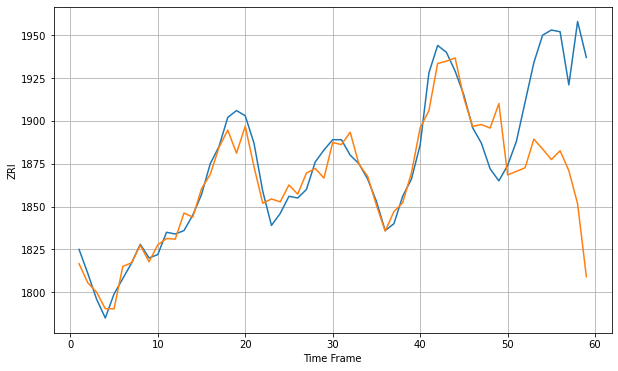

Wall time: 9.02 s
60614 8.401460334516727 65.51608050233213


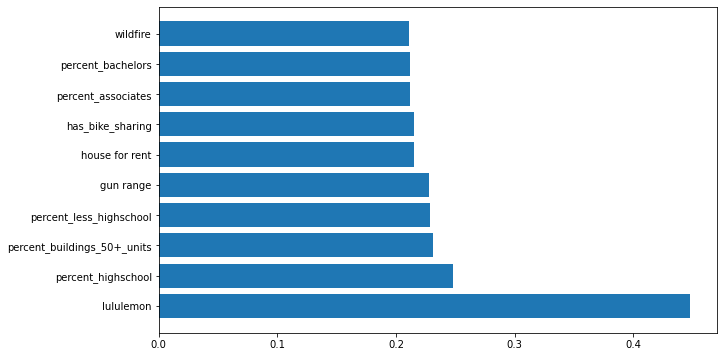


Got an mse at 0.0025 in epoch 46 and stopped training



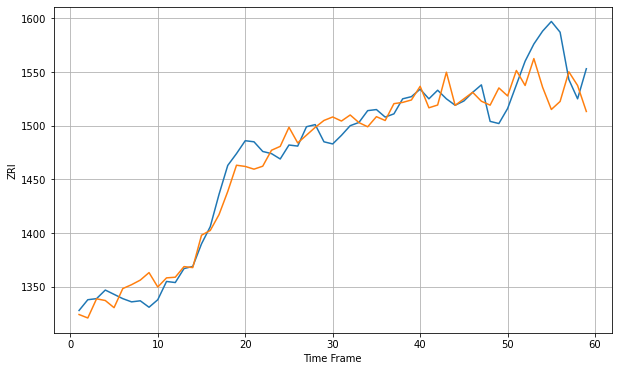

Wall time: 9.02 s
60615 13.318181664756256 38.42370416777333


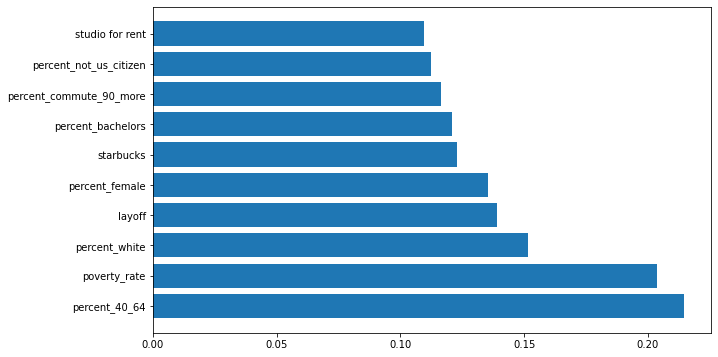


Got an mse at 0.0025 in epoch 50 and stopped training



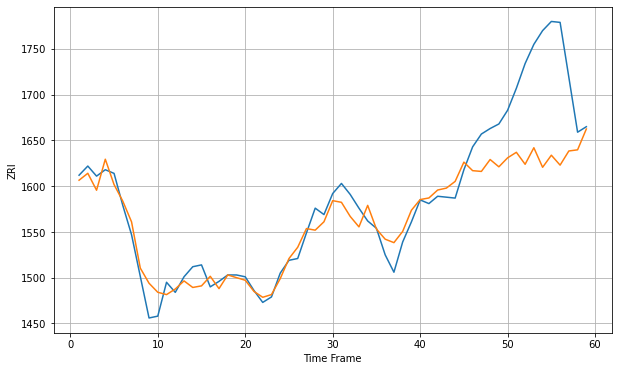

Wall time: 9.58 s
60616 15.800871190967815 96.03390268843391


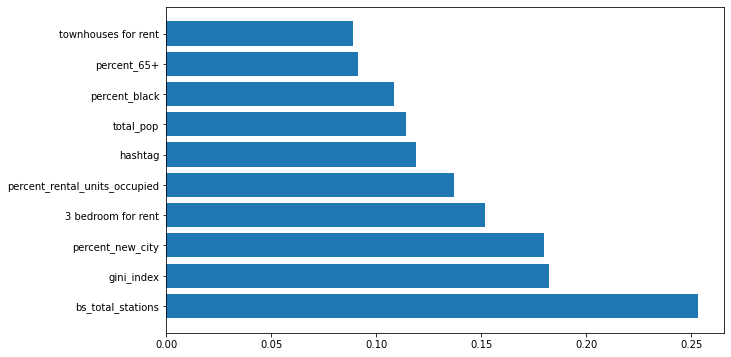


Got an mse at 0.0025 in epoch 79 and stopped training



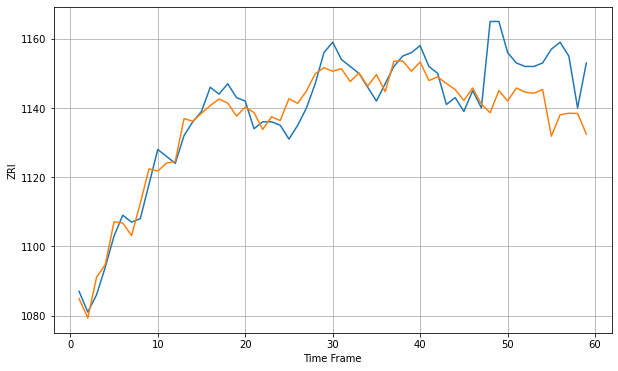

Wall time: 10.6 s
60617 4.167780089295126 16.552026249609742


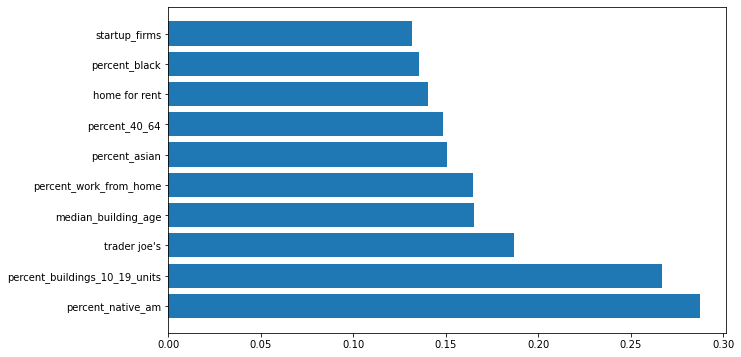


Got an mse at 0.0025 in epoch 105 and stopped training



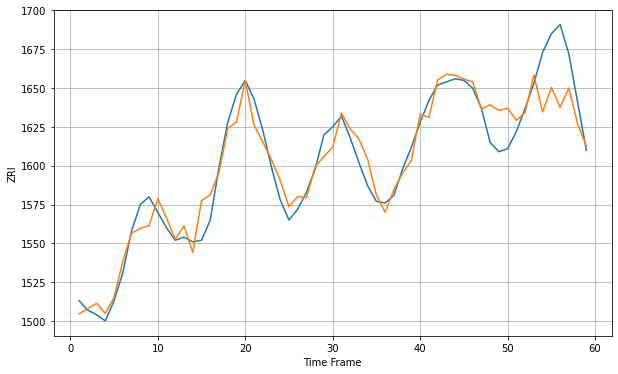

Wall time: 11.9 s
60618 9.474208650496037 26.252856605833024


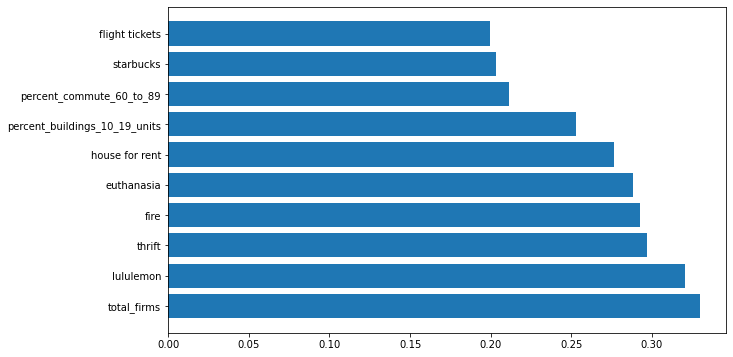


Got an mse at 0.0024 in epoch 44 and stopped training



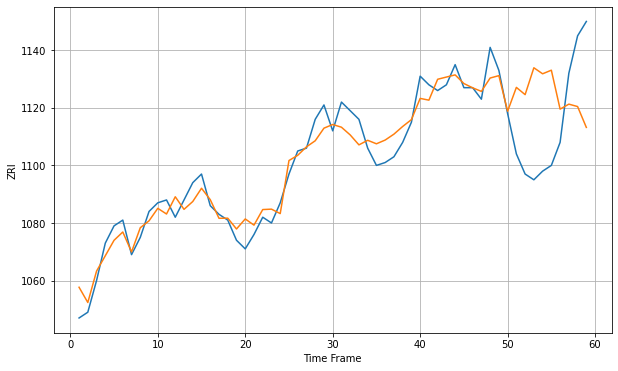

Wall time: 9.37 s
60619 5.23341892888781 24.781612942787593


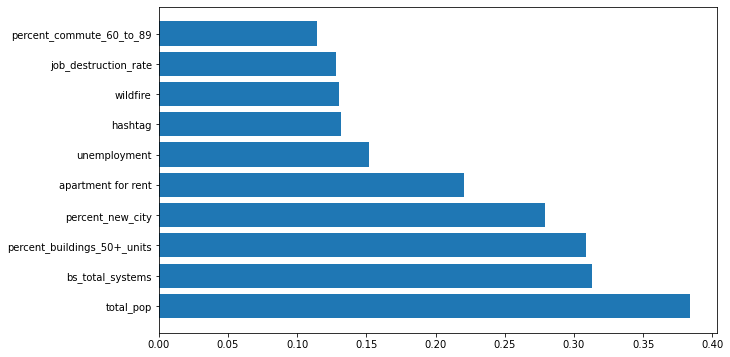


Got an mse at 0.0025 in epoch 31 and stopped training



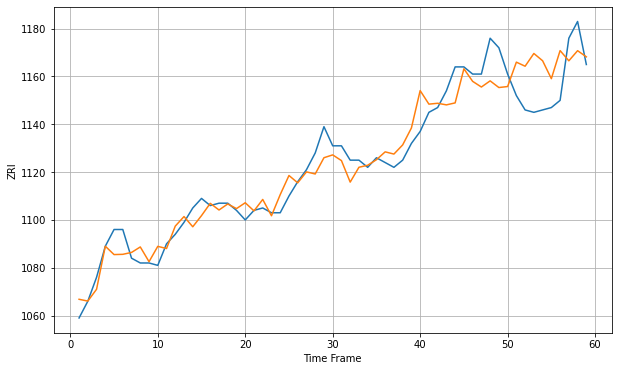

Wall time: 9 s
60620 6.348638361110189 15.835602880936905


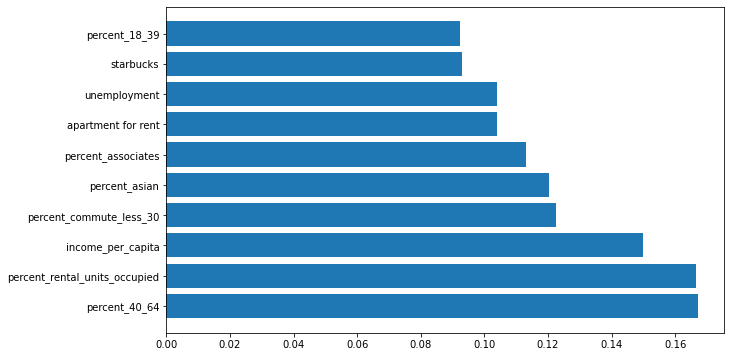


Got an mse at 0.0025 in epoch 82 and stopped training



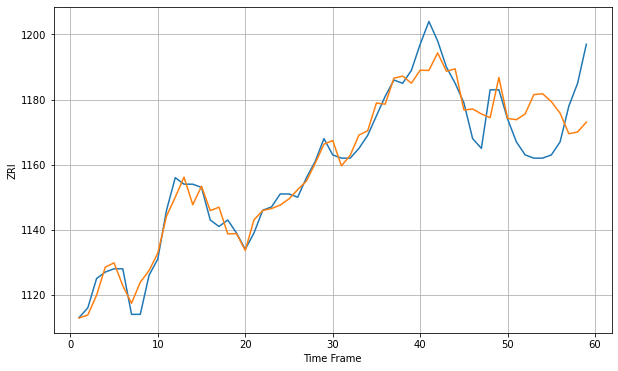

Wall time: 10.2 s
60621 4.557670975192949 13.785664276343567


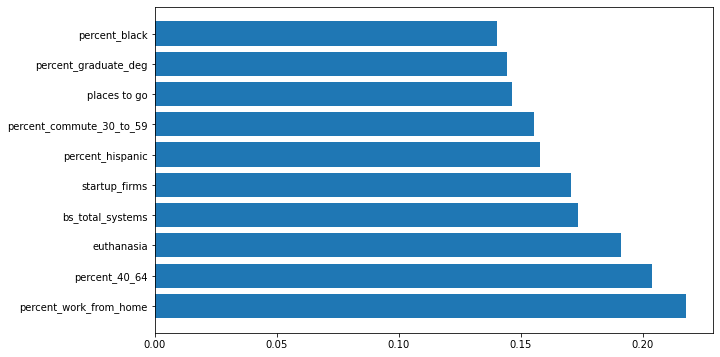


Got an mse at 0.0025 in epoch 67 and stopped training



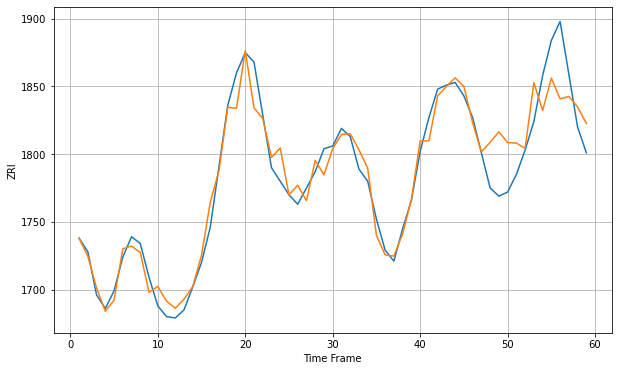

Wall time: 9.85 s
60622 10.669187451855917 31.314110187894805


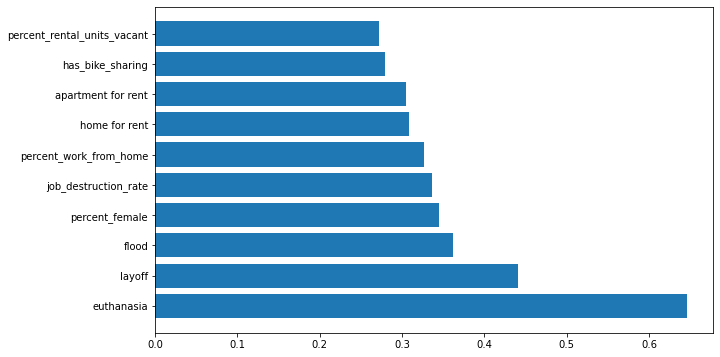


Got an mse at 0.0025 in epoch 75 and stopped training



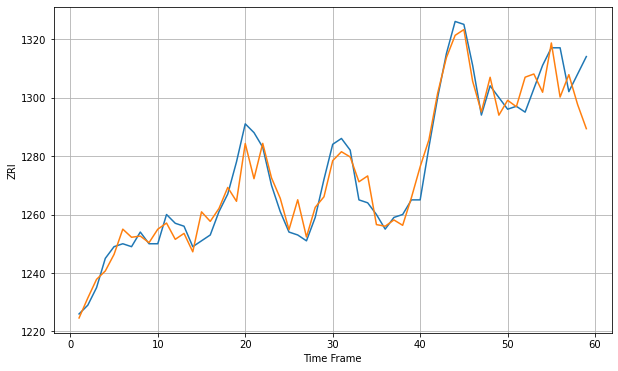

Wall time: 10.1 s
60623 5.417019436470044 10.579308232534768


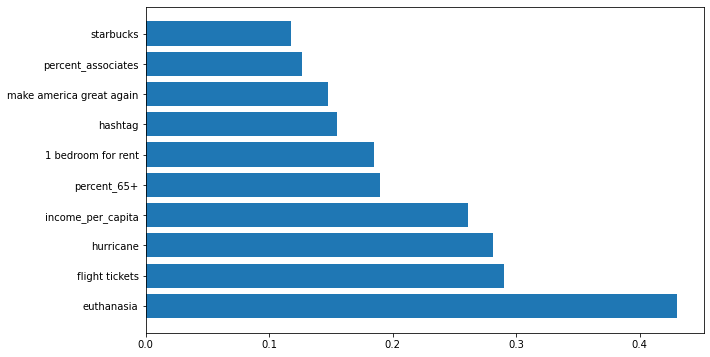


Got an mse at 0.0025 in epoch 72 and stopped training



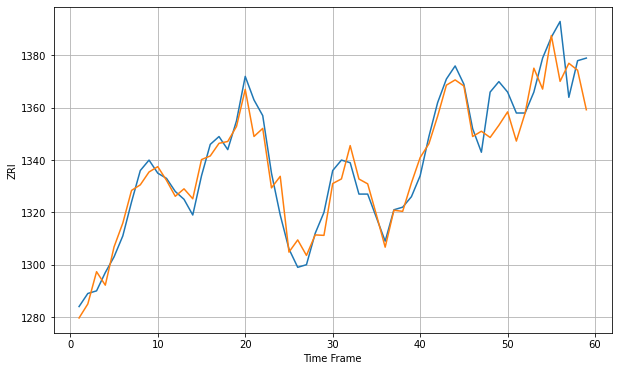

Wall time: 10.1 s
60624 5.564428871863916 13.145886284808626


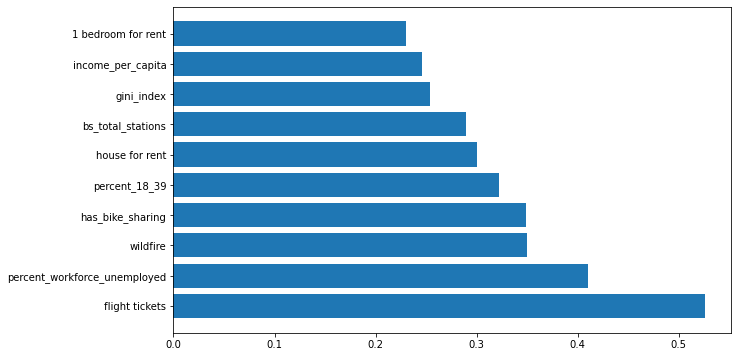


Got an mse at 0.0025 in epoch 122 and stopped training



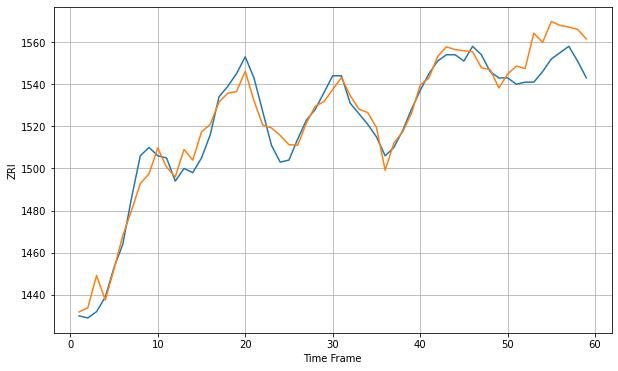

Wall time: 11.7 s
60625 6.385157834300881 12.941964915247356


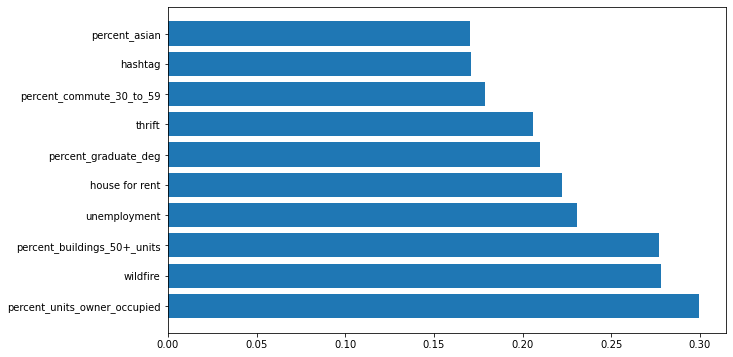


Got an mse at 0.0025 in epoch 83 and stopped training



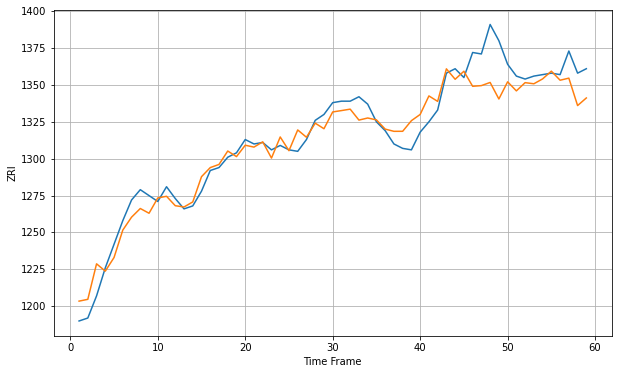

Wall time: 10.9 s
60626 9.876911751138175 19.62023102527482


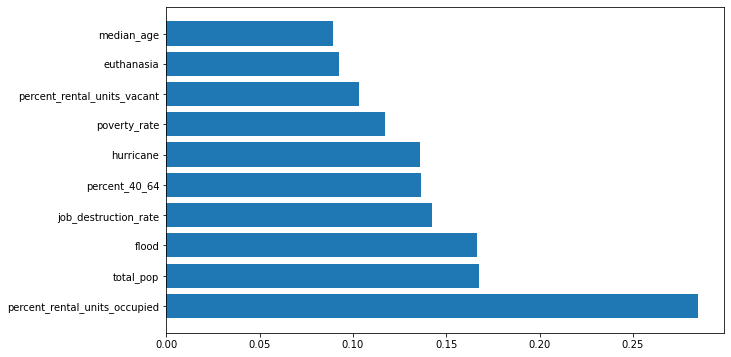


Got an mse at 0.0025 in epoch 144 and stopped training



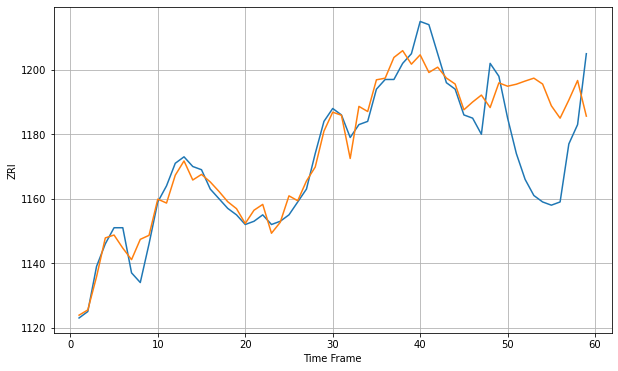

Wall time: 12.1 s
60628 4.911258387764653 23.671324401061884


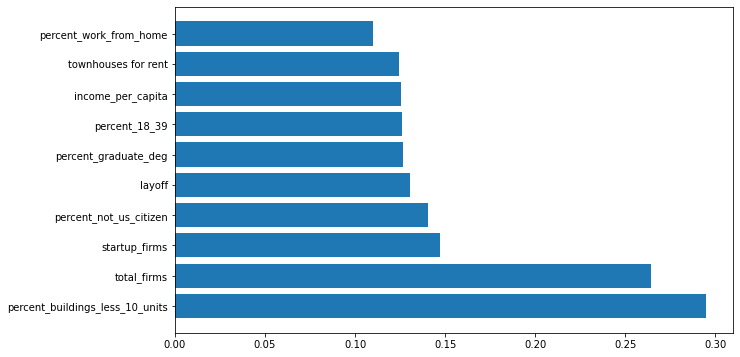


Got an mse at 0.0024 in epoch 61 and stopped training



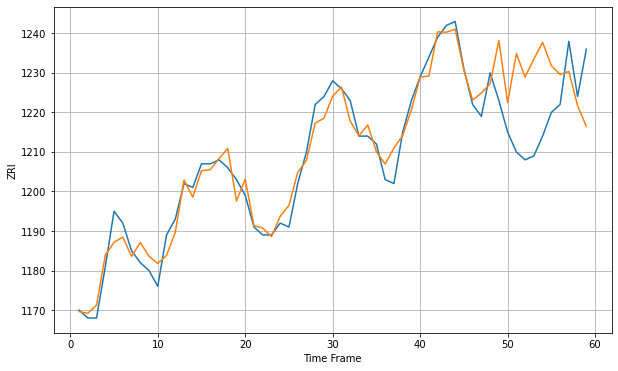

Wall time: 9.92 s
60629 3.616886538247442 16.220427435807867


In [ ]:
score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "importance":[]};
with tf.device('/cpu:0'):
    # for ZONE in zip_ids:
    for ZONE in zip_ids[START_NUM:END_NUM]:
        %time M_train, M_test, model, scaler, series_transformed =\
        NN_test(ZONE, termination=0.0025, plot=True);
        print(ZONE, M_train, M_test);

        score_dict["zip"].append(ZONE);
        score_dict["RMSE_train"].append(M_train);
        score_dict["RMSE_test"].append(M_test);
        
        # Computing the feature importance
        
        results, actual = NN_forecast(model, series_transformed);
        mse = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5;
        perm_importance = [];
        TRIALS = 2;
        PLOT_IMPORTANCE = True;
        
        for i in range(1, len(feature_name)):
            mse_feat = [];
            for _ in range(TRIALS):
                seq_perm = series_transformed.copy();
                seq_perm[:, i] = np.random.permutation(seq_perm[:,i])
                results, actual = NN_forecast(model, seq_perm);
                mse_feat.append(mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5);
                
            perm_importance.append(sum(mse_feat)/TRIALS/mse - 1.0);
        
        importance = pd.DataFrame({"Feature": feature_name[1:], "Importance": perm_importance});
        importance.sort_values("Importance", ascending = False, inplace = True);
        
        plt.figure(figsize=(10, 6));
        plt.barh(importance["Feature"][:10], importance["Importance"][:10]);
        plt.show();
        
        score_dict["importance"].append(perm_importance);

In [ ]:
print(sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]));

In [ ]:
test = pd.DataFrame(score_dict);
test.to_csv('NN_feature_window_1_overoverfit_importance_6.csv', index = False);